One of the goals of this analysis is to see whether it is possible to find a model that will accurately predict the Site Energy Use (The annual amount of energy consumed by the property from all sources of energy). I will also evaluate the usefulness of the energy star score to predict a building's energy use. 

The energy start score is an EPA calculated 1-100 rating that assesses a> property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median while a score of 75 or higher indicates your building is a top performer and may be eligible for ENERGY STAR certification. It might be interesting to help predict a building's energy consumption.

After exploring and transforming the data in the EDA, I will test various models to find out which one has the best performance to predict the Site Energy Use (The annual amount of energy consumed by the property from all sources of energy).

I will use the previously made functions to transform the data and make it ready for ML algorithms testing.

# 1. Importing librairies

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Librairies for EDA functions
#KNN 
from sklearn.impute import KNNImputer
#Encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
#Centering and standardising
from sklearn.preprocessing import StandardScaler

#Librairies for models testing
#Train test split
from sklearn.model_selection import train_test_split

#Understanding the model and its performances

#Import Linear model librarie
from sklearn.linear_model import LinearRegression

#Import grid search library
from sklearn.model_selection import GridSearchCV, KFold

#Displaying the mean squared error
from sklearn.metrics import mean_squared_error
#Displaying the coefficient of determination
from sklearn.metrics import r2_score
#Calculating the p value
from scipy import stats

#Lasso
from sklearn.linear_model import Lasso

#Import Random Forest libraries
from sklearn.ensemble import RandomForestRegressor
#Random forest features selection 
from sklearn.feature_selection import SelectFromModel
#Accuracy score
from sklearn.metrics import accuracy_score
#Processing time
import timeit
#Cross Validation
from sklearn.model_selection import cross_val_score

#Gradient Boosting
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform, randint

#SVR
from sklearn.svm import SVR, LinearSVR

#SHapley Additive exPlanations
import shap
from IPython.display import display

# 2. Applying functions

In [2]:
def all_treatments(df):
    #Deleting non residential buildings
    df = df.loc[df['BuildingType'].str.contains("NonResidential|Nonresidential COS|SPS-District K-12|Campus|Nonresidential WA")]
    #Deleting the Residence Halls
    df = df.loc[df['PrimaryPropertyType'] != 'Residence Hall']
    #Deleting Senior Care Community
    df = df.loc[df['PrimaryPropertyType'] != 'Senior Care Community']
    #Deleting Low-Rise Multifamily
    df = df.loc[df['PrimaryPropertyType'] != 'Low-Rise Multifamily']
    #Dropping unecessary columns
    df = df.drop(columns = ['OSEBuildingID','DataYear','Comments','City','State','TaxParcelIdentificationNumber'])
    #Turning 0s into 1 for the number of buildings
    df.loc[df['NumberofBuildings'] == 0, ['NumberofBuildings']] = 1
    #Deleting properties above 30 buildings
    df = df.loc[df['NumberofBuildings'] < 30]
    #Deleting the chinese baptist church
    df = df.loc[df['PropertyName'] != 'Seattle Chinese Baptist Church']
    
    #Deleting outliers in LargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Entire Campus']
    df = df.loc[df['PropertyName'] != 'Columbia Center - 2015']
    df = df.loc[df['PropertyName'] != 'Swedish First Hill']
    df = df.loc[df['PropertyName'] != 'CenturyLink']

    #Deleting outliers in SecondLargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Washington State Convention Center']
    df = df.loc[df['PropertyName'] != 'Plant 2 Site']

    #Deleting outliers in ThirdLargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Russell Investments Center']
    
    #Deleting wheather normalized variables
    df = df.drop(columns = ['SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)'])

    #Deleting buildings with default data
    df = df.loc[df['DefaultData'] == False]
    #Deleting non compliant buildings
    df = df.loc[df['ComplianceStatus'] == 'Compliant']
        
    #Grouping neighborhoods based on their names
    #Turning Nort into NORTH
    df.loc[df['Neighborhood'].str.contains('NORTH|North'), 'Neighborhood'] = 'NORTH'
    #Turning Delridge into DELRIDGE
    df.loc[df['Neighborhood'].str.contains('DELRIDGE|DELRIDGE NEIGHBORHOODS|Delridge'), 'Neighborhood'] = 'DELRIDGE'
    #Ballard into BALLARD
    df.loc[df['Neighborhood'].str.contains('BALLARD|Ballard'), 'Neighborhood'] = 'BALLARD'
    #Northwest into NORTHWEST
    df.loc[df['Neighborhood'].str.contains('NORTHWEST|Northwest'), 'Neighborhood'] = 'NORTHWEST'
    #Central into CENTRAL
    df.loc[df['Neighborhood'].str.contains('CENTRAL|Central'), 'Neighborhood'] = 'CENTRAL'
    #Turning all non residential buildings into the same label 'NonResidential'
    df.loc[df['BuildingType'].str.contains('Nonresidential COS|Nonresidential WA'), ['BuildingType']] = 'NonResidential'
    
    #Grouping primary property types
    new_value = 'Offices'
    new_value_2 = 'Mixed Use Property and Other'
    new_value_3 = 'Retail and Supermarkets'
    new_value_4 = 'Storage Facilities'
    
    #Grouping all kind of offices
    df.loc[df['PrimaryPropertyType'].str.contains('Small- and Mid-Sized Office|Large Office|Medical Office'),
                  'PrimaryPropertyType'] = new_value
    
    #Grouping all mixed used properties and other
    df.loc[df['PrimaryPropertyType'].str.contains('Mixed Use Property|Other'),'PrimaryPropertyType'] = new_value_2
    
    #Grouping retail stores and supermarket, although alimentation stores might use more energy, there are both stores
    df.loc[df['PrimaryPropertyType'].str.contains('Retail Store|Supermarket / Grocery Store'),'PrimaryPropertyType'] = new_value_3
    
    #Grouping self storage facility and warehouses and distribution center. They all consist in a storage for various goods
    df.loc[df['PrimaryPropertyType'].str.contains('Self-Storage Facility|Warehouse|Distribution Center'),
                  'PrimaryPropertyType'] = new_value_4

    #LargestPropertyUseType Treatments
    #Turning all values in LargestPropertyUseType into strings
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].astype(str)

    #Deleting building with a residential largest Property Type 
    df = df.loc[~df['LargestPropertyUseType'].str.contains("Other - Lodging/Residential|Multifamily Housing|Residence Hall/Dormitory|Residential Care Facility")]
    
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'

    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].replace(replacement_mapping)

    #SecondLargestPropertyUseType Treatments
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'
    
    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Vocational School' : Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Convenience Store without Gas Station' : Largest_value_6,
        'Food Sales' : Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Enclosed Mall' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Bar/Nightclub' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].replace(replacement_mapping)

    #ThirdLargestPropertyUseType Treatments
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'
    
    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Vocational School' : Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Convenience Store without Gas Station' : Largest_value_6,
        'Food Sales' : Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Enclosed Mall' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Bar/Nightclub' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].replace(replacement_mapping)
    
    #Unecessary columns deletion
    df = df.drop(columns = ['Outlier','ComplianceStatus','Address','PropertyName','YearsENERGYSTARCertified','ListOfAllPropertyUseTypes',
                                                      'DefaultData','Electricity(kWh)','Latitude','Longitude','NaturalGas(therms)','ZipCode'])


    #LargestPropertyUseType treatments
    #Deleting the lines where LargestPropertyUseType is empty
    df = df.loc[ ~ df['LargestPropertyUseType'].str.contains("nan")]

    #SecondLargestPropertyUseType
    #Replacing nans in SecondLargestPropertyUseType with "No_Second_Type"
    df.loc[df['SecondLargestPropertyUseType'].isna(), ['SecondLargestPropertyUseType']] = "No_Second_Type"
    #Replacing nans in SecondLargestPropertyUseTypeGFA with 0
    df.loc[df['SecondLargestPropertyUseTypeGFA'].isna(), ['SecondLargestPropertyUseTypeGFA']] = 0

    #ThirdLargestPropertyUseType
    #Replacing nans in ThirdLargestPropertyUseType with "No_Third_Type"
    df.loc[df['ThirdLargestPropertyUseType'].isna(), ['ThirdLargestPropertyUseType']] = "No_Third_Type"
    #Replacing nans in ThirdLargestPropertyUseTypeGFA with 0
    df.loc[df['ThirdLargestPropertyUseTypeGFA'].isna(), ['ThirdLargestPropertyUseTypeGFA']] = 0

    
    
    #Using KNN to impute EnergyStar Score
    imputer = KNNImputer(n_neighbors = 3, weights = 'uniform')
    #Creating a dataset with numerical columns only to use the KNNs
    knn_data = df.loc[:,['YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','ENERGYSTARScore','SiteEUI(kBtu/sf)',
    'SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity']]
    #Fit and transform the dataset with the imputer, turning it into a pandas dataframe
    knn_imputed = pd.DataFrame(imputer.fit_transform(knn_data))
    #Giving the same columns names
    knn_imputed.columns = knn_data.columns
    
    #Resetting data with missing index
    df = df.reset_index()
    #Dropping new index column 
    df = df.drop(columns = ['index'])
    
    #Replacing initial energystar column with the imputed column
    df['ENERGYSTARScore'] = knn_imputed.ENERGYSTARScore

    #Creating a dataframe with the energystar score
    df_with_energy = df.drop(columns = ['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','GHGEmissionsIntensity'])
    
    return df_with_energy

In [3]:
def standardising_encoding(df):

    #Setting the encoder
    enc = OneHotEncoder(handle_unknown='error', sparse_output = False).set_output(transform = 'pandas')
    #Fitting the encoder and transforming the data
    enc_tranform = enc.fit_transform(df[['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']])
    #Merging the final data with the encoded data. Dropping unecessary columns
    final_encoded = pd.concat([df,enc_tranform], axis = 1).drop(columns = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType'])
    
    # Instanciating the scaler :
    scaler = StandardScaler()
    # Fitting the scaler to the data and transforming it to obtain a normalise and standardised dataframe.
    scaled_df = scaler.fit_transform(final_encoded)
    # Turning it into a new dataframe 
    scaled_df = pd.DataFrame(scaled_df)
    #Assingning columns names
    scaled_df.columns = final_encoded.columns

    return scaled_df

In [4]:
#Applying the fuctions to the initial dataset
entire_data = pd.read_csv("Building_Energy_Benchmarking.csv")

transformed_data = all_treatments(entire_data)
data = standardising_encoding(transformed_data)

In [5]:
data

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseType_Other,ThirdLargestPropertyUseType_Other - Technology/Science,ThirdLargestPropertyUseType_Other - Utility,ThirdLargestPropertyUseType_Parking,ThirdLargestPropertyUseType_Recreational Venues,ThirdLargestPropertyUseType_Repair and Public Services,ThirdLargestPropertyUseType_Retail/Mall,ThirdLargestPropertyUseType_School,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Warehouse
0,1.170103,-1.051058,-0.117972,1.307475,-0.125572,-0.319949,-0.053008,-0.006213,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
1,1.170103,1.060028,-0.117972,1.141527,-0.037796,0.030898,-0.052552,-0.038679,-0.078927,0.147929,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
2,1.170103,0.233951,-0.117972,6.119978,4.907528,4.261700,4.443048,4.756454,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
3,1.170103,-1.081654,-0.117972,0.975579,-0.282851,-0.319949,-0.234697,-0.199511,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
4,1.170103,0.570501,-0.117972,2.303165,0.379933,1.124058,0.115494,0.243385,1.043423,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,12.111978,-0.117162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,-1.547259,0.631692,-0.117972,-0.517957,-0.532622,-0.319949,-0.523234,-0.506484,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
1473,-1.094365,1.304792,-0.117972,-0.517957,-0.545737,-0.319949,-0.538384,-0.522603,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
1474,1.170103,0.386928,-0.117972,-0.517957,-0.562229,-0.319949,-0.557435,-0.582608,-0.280100,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,12.111978,-0.117162
1475,-1.547259,0.845860,-0.117972,-0.517957,-0.556753,-0.319949,-0.551110,-0.589609,-0.260449,-0.193612,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,11.049133,-0.082563,-0.117162


In [6]:
data.columns

Index(['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       ...
       'ThirdLargestPropertyUseType_Other',
       'ThirdLargestPropertyUseType_Other - Technology/Science',
       'ThirdLargestPropertyUseType_Other - Utility',
       'ThirdLargestPropertyUseType_Parking',
       'ThirdLargestPropertyUseType_Recreational Venues',
       'ThirdLargestPropertyUseType_Repair and Public Services',
       'ThirdLargestPropertyUseType_Retail/Mall',
       'ThirdLargestPropertyUseType_School',
       'ThirdLargestPropertyUseType_Swimming Pool',
       'ThirdLargestPropertyUseType_Warehouse'],
      dtype='object', length=112)

# 3. Linear model testing - Site Energy Use

Linear regression will try find the line equation that allows you to best predict the Site Energy Use based on the values of other variables.

I will also use Lasso regression to see which one gives the best results.

Both Ridge and Lasso are linear regressions that add a bias to the line final equation to avoid overfitting the model to the traning data. 

They both take the sum of squared residuals and add a bias, with ridge regression, the bias is squared, while in lasso regression, the bias is in absolute value.

The other difference is that Ridge regression can minimise variables that are not useful to estimate the target variable, while Lasso regression can totally eliminate them.

To have a baseline and be able to see whether regularisation with Ridge and Lasso regressions truly improves the results, I will first perform an classical regression and see the mean squared error.

## 3.1 Linear regression

To improve the model's performance I will use bagging (Bootstrap Aggregating)

Bagging will create sub datasets from the inital dataset and then train a linear model on each subset. 

Once all models have been trained, they will all be aggregated using the mean of each prediction to propose a final prediction (or a majority vote for a classification model).

To avoid overfitting the model to the training data, I will also use cross validation 

### 3.1.1 All variables - 5 folds cross validation

I will first try to use all variables to create a model, although there are a lot of columns due to encoding, it might be interesting to see which ones are most important to the model.

I will not use ENERGYSTARScore, SiteEnergyUse(kBtu), TotalGHGEmissions as input to the model

In [7]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode','YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','BuildingType_Campus',
'BuildingType_NonResidential','BuildingType_SPS-District K-12','PrimaryPropertyType_Hotel','PrimaryPropertyType_K-12 School','PrimaryPropertyType_Laboratory',
'PrimaryPropertyType_Mixed Use Property and Other','PrimaryPropertyType_Offices','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility','Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE',
'Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER DUWAMISH','Neighborhood_LAKE UNION','Neighborhood_MAGNOLIA / QUEEN ANNE','Neighborhood_NORTH',
'Neighborhood_SOUTHEAST','Neighborhood_SOUTHWEST','LargestPropertyUseType_Fitness Center/Health Club/Gym','LargestPropertyUseType_Food/Drink Services',
'LargestPropertyUseType_Hotel','LargestPropertyUseType_Laboratory','LargestPropertyUseType_Library','LargestPropertyUseType_Museum',
'LargestPropertyUseType_Office','LargestPropertyUseType_Other','LargestPropertyUseType_Other - Utility','LargestPropertyUseType_Parking',
'LargestPropertyUseType_Performing Arts','LargestPropertyUseType_Recreational Venues','LargestPropertyUseType_Repair and Public Services',
'LargestPropertyUseType_Retail/Mall','LargestPropertyUseType_School','LargestPropertyUseType_Warehouse','LargestPropertyUseType_Worship Facility',
'SecondLargestPropertyUseType_Bank Branch','SecondLargestPropertyUseType_Data Center','SecondLargestPropertyUseType_Fitness Center/Health Club/Gym',
'SecondLargestPropertyUseType_Food/Drink Services','SecondLargestPropertyUseType_Hotel','SecondLargestPropertyUseType_Laboratory',
'SecondLargestPropertyUseType_Manufacturing/Industrial Plant','SecondLargestPropertyUseType_Multifamily Housing','SecondLargestPropertyUseType_Office',
'SecondLargestPropertyUseType_Other','SecondLargestPropertyUseType_Parking','SecondLargestPropertyUseType_Performing Arts',
'SecondLargestPropertyUseType_Recreational Venues','SecondLargestPropertyUseType_Repair and Public Services',
'SecondLargestPropertyUseType_Residence Hall/Dormitory','SecondLargestPropertyUseType_Retail/Mall','SecondLargestPropertyUseType_School',
'SecondLargestPropertyUseType_Warehouse','SecondLargestPropertyUseType_Worship Facility','ThirdLargestPropertyUseType_Bank Branch',
'ThirdLargestPropertyUseType_Data Center','ThirdLargestPropertyUseType_Fast Food Restaurant','ThirdLargestPropertyUseType_Fitness Center/Health Club/Gym',
'ThirdLargestPropertyUseType_Food/Drink Services','ThirdLargestPropertyUseType_Hospital',
'ThirdLargestPropertyUseType_Hotel','ThirdLargestPropertyUseType_Laboratory','ThirdLargestPropertyUseType_Manufacturing/Industrial Plant',
'ThirdLargestPropertyUseType_Multifamily Housing','ThirdLargestPropertyUseType_Office','ThirdLargestPropertyUseType_Other',
'ThirdLargestPropertyUseType_Other - Technology/Science','ThirdLargestPropertyUseType_Other - Utility','ThirdLargestPropertyUseType_Parking',
'ThirdLargestPropertyUseType_Recreational Venues','ThirdLargestPropertyUseType_Repair and Public Services','ThirdLargestPropertyUseType_Retail/Mall',
'ThirdLargestPropertyUseType_School','ThirdLargestPropertyUseType_Swimming Pool','ThirdLargestPropertyUseType_Warehouse']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [8]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 544 to 1126
Data columns (total 90 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   CouncilDistrictCode                                          1033 non-null   float64
 1   YearBuilt                                                    1033 non-null   float64
 2   NumberofBuildings                                            1033 non-null   float64
 3   NumberofFloors                                               1033 non-null   float64
 4   PropertyGFATotal                                             1033 non-null   float64
 5   PropertyGFAParking                                           1033 non-null   float64
 6   PropertyGFABuilding(s)                                       1033 non-null   float64
 7   LargestPropertyUseTypeGFA                                    1033 non-null   floa

In [10]:
print(y_train.info())

<class 'pandas.core.series.Series'>
Index: 1033 entries, 544 to 1126
Series name: SiteEnergyUse(kBtu)
Non-Null Count  Dtype  
--------------  -----  
1033 non-null   float64
dtypes: float64(1)
memory usage: 16.1 KB
None


In [11]:
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 444 entries, 1233 to 714
Data columns (total 90 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   CouncilDistrictCode                                          444 non-null    float64
 1   YearBuilt                                                    444 non-null    float64
 2   NumberofBuildings                                            444 non-null    float64
 3   NumberofFloors                                               444 non-null    float64
 4   PropertyGFATotal                                             444 non-null    float64
 5   PropertyGFAParking                                           444 non-null    float64
 6   PropertyGFABuilding(s)                                       444 non-null    float64
 7   LargestPropertyUseTypeGFA                                    444 non-null    float

In [12]:
print(y_test.info())

<class 'pandas.core.series.Series'>
Index: 444 entries, 1233 to 714
Series name: SiteEnergyUse(kBtu)
Non-Null Count  Dtype  
--------------  -----  
444 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB
None


### 3.1.2 - 5 Folds Cross Validation

In [13]:
#Initiating the Linear Regression model
model = LinearRegression()

In [14]:
#Defining hyperparameters to search
#Testing with fit intercept true and false to see which one gives the best result
param_grid = {
    'fit_intercept': [True, False]
}

In [15]:
#Initiating cross validation search, with 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')

In [16]:
#Use the model and cross validation on the training data 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [17]:
# Function to calculate p-value
def calculate_p_value(y_true, y_pred, dof):
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    mse_res = rss / dof
    mse_model = mean_squared_error(y_true, y_pred)
    f = mse_model / mse_res
    p_value = 1 - stats.f.cdf(f, X_test.shape[1], dof)
    return p_value

#Saving the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the model to predict y, based on X_Test
predictions = best_model.predict(X_test)

# Accessing results of the grid search
results = grid_search.cv_results_
intercepts = results['param_fit_intercept']
mean_squared_errors = -results['mean_test_score']

# Loop through each model's results
for i in range(len(intercepts)):
    # Extracting model parameters
    intercept = intercepts[i]
    mse = mean_squared_errors[i]
    r2 = r2_score(y_test, predictions)
    
    # Calculating p-value
    p_value = calculate_p_value(y_test, predictions, len(y_test) - X_test.shape[1] - 1)

    # Printing results
    print(f"Model {i+1}:")
    print(f"  Fit Intercept: {intercept}")
    print(f"  R2 Score: {r2}")
    print(f"  Mean Squared Error: {mse}")
    print(f"  P-value: {p_value}")

# For the best model
best_intercept = best_model.fit_intercept
best_predictions = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)
best_p_value = calculate_p_value(y_test, best_predictions, len(y_test) - X_test.shape[1] - 1)

# Printing results for the best model
print("Best Model:")
print(f"  Fit Intercept: {best_intercept}")
print(f"  R2 Score: {best_r2}")
print(f"  Mean Squared Error: {best_mse}")
print(f"  P-value: {best_p_value}")

Model 1:
  Fit Intercept: True
  R2 Score: -2.571917041129635e+18
  Mean Squared Error: 1.9615785128840835e+22
  P-value: 0.9044127507753225
Model 2:
  Fit Intercept: False
  R2 Score: -2.571917041129635e+18
  Mean Squared Error: 1.9597757976244857e+21
  P-value: 0.9044127507753225
Best Model:
  Fit Intercept: False
  R2 Score: -2.571917041129635e+18
  Mean Squared Error: 2.857143853558209e+18
  P-value: 0.9044127507753225


R2 Score is really bad (even negative). it might be because the selected variables don't help the model to obtain a good prediction, or because the model is "polluted" with too many variables.

In [18]:
# Accessing the coefficients of the best model
coefficients = best_model.coef_

# Getting the names of the features
feature_names = X.columns

# Associating coefficients with feature names
feature_coefficients = list(zip(feature_names, coefficients))

# Displaying the impact of each variable on the regression
print("\nImpact of each variable on the regression:")
for feature, coefficient in feature_coefficients:
    print(f"{feature}: {coefficient}")


Impact of each variable on the regression:
CouncilDistrictCode: -0.007822133692147064
YearBuilt: 0.036389763529746155
NumberofBuildings: 0.09482175650781072
NumberofFloors: 0.182015980544801
PropertyGFATotal: 20374572606.760723
PropertyGFAParking: -5074447373.484236
PropertyGFABuilding(s): -17637219463.82004
LargestPropertyUseTypeGFA: 0.06943364467481454
SecondLargestPropertyUseTypeGFA: 0.02787579531917847
ThirdLargestPropertyUseTypeGFA: -0.04567694907264111
BuildingType_Campus: 10220992511.772913
BuildingType_NonResidential: 12475075690.34708
BuildingType_SPS-District K-12: 7252092808.1262665
PrimaryPropertyType_Hotel: -0.421341279487636
PrimaryPropertyType_K-12 School: -0.142069369392986
PrimaryPropertyType_Laboratory: -0.1998824398657179
PrimaryPropertyType_Mixed Use Property and Other: -1.0307481176618505
PrimaryPropertyType_Offices: -1.1709529935601637
PrimaryPropertyType_Restaurant: -0.2467066984633678
PrimaryPropertyType_Retail and Supermarkets: -0.6900678273972214
PrimaryPrope

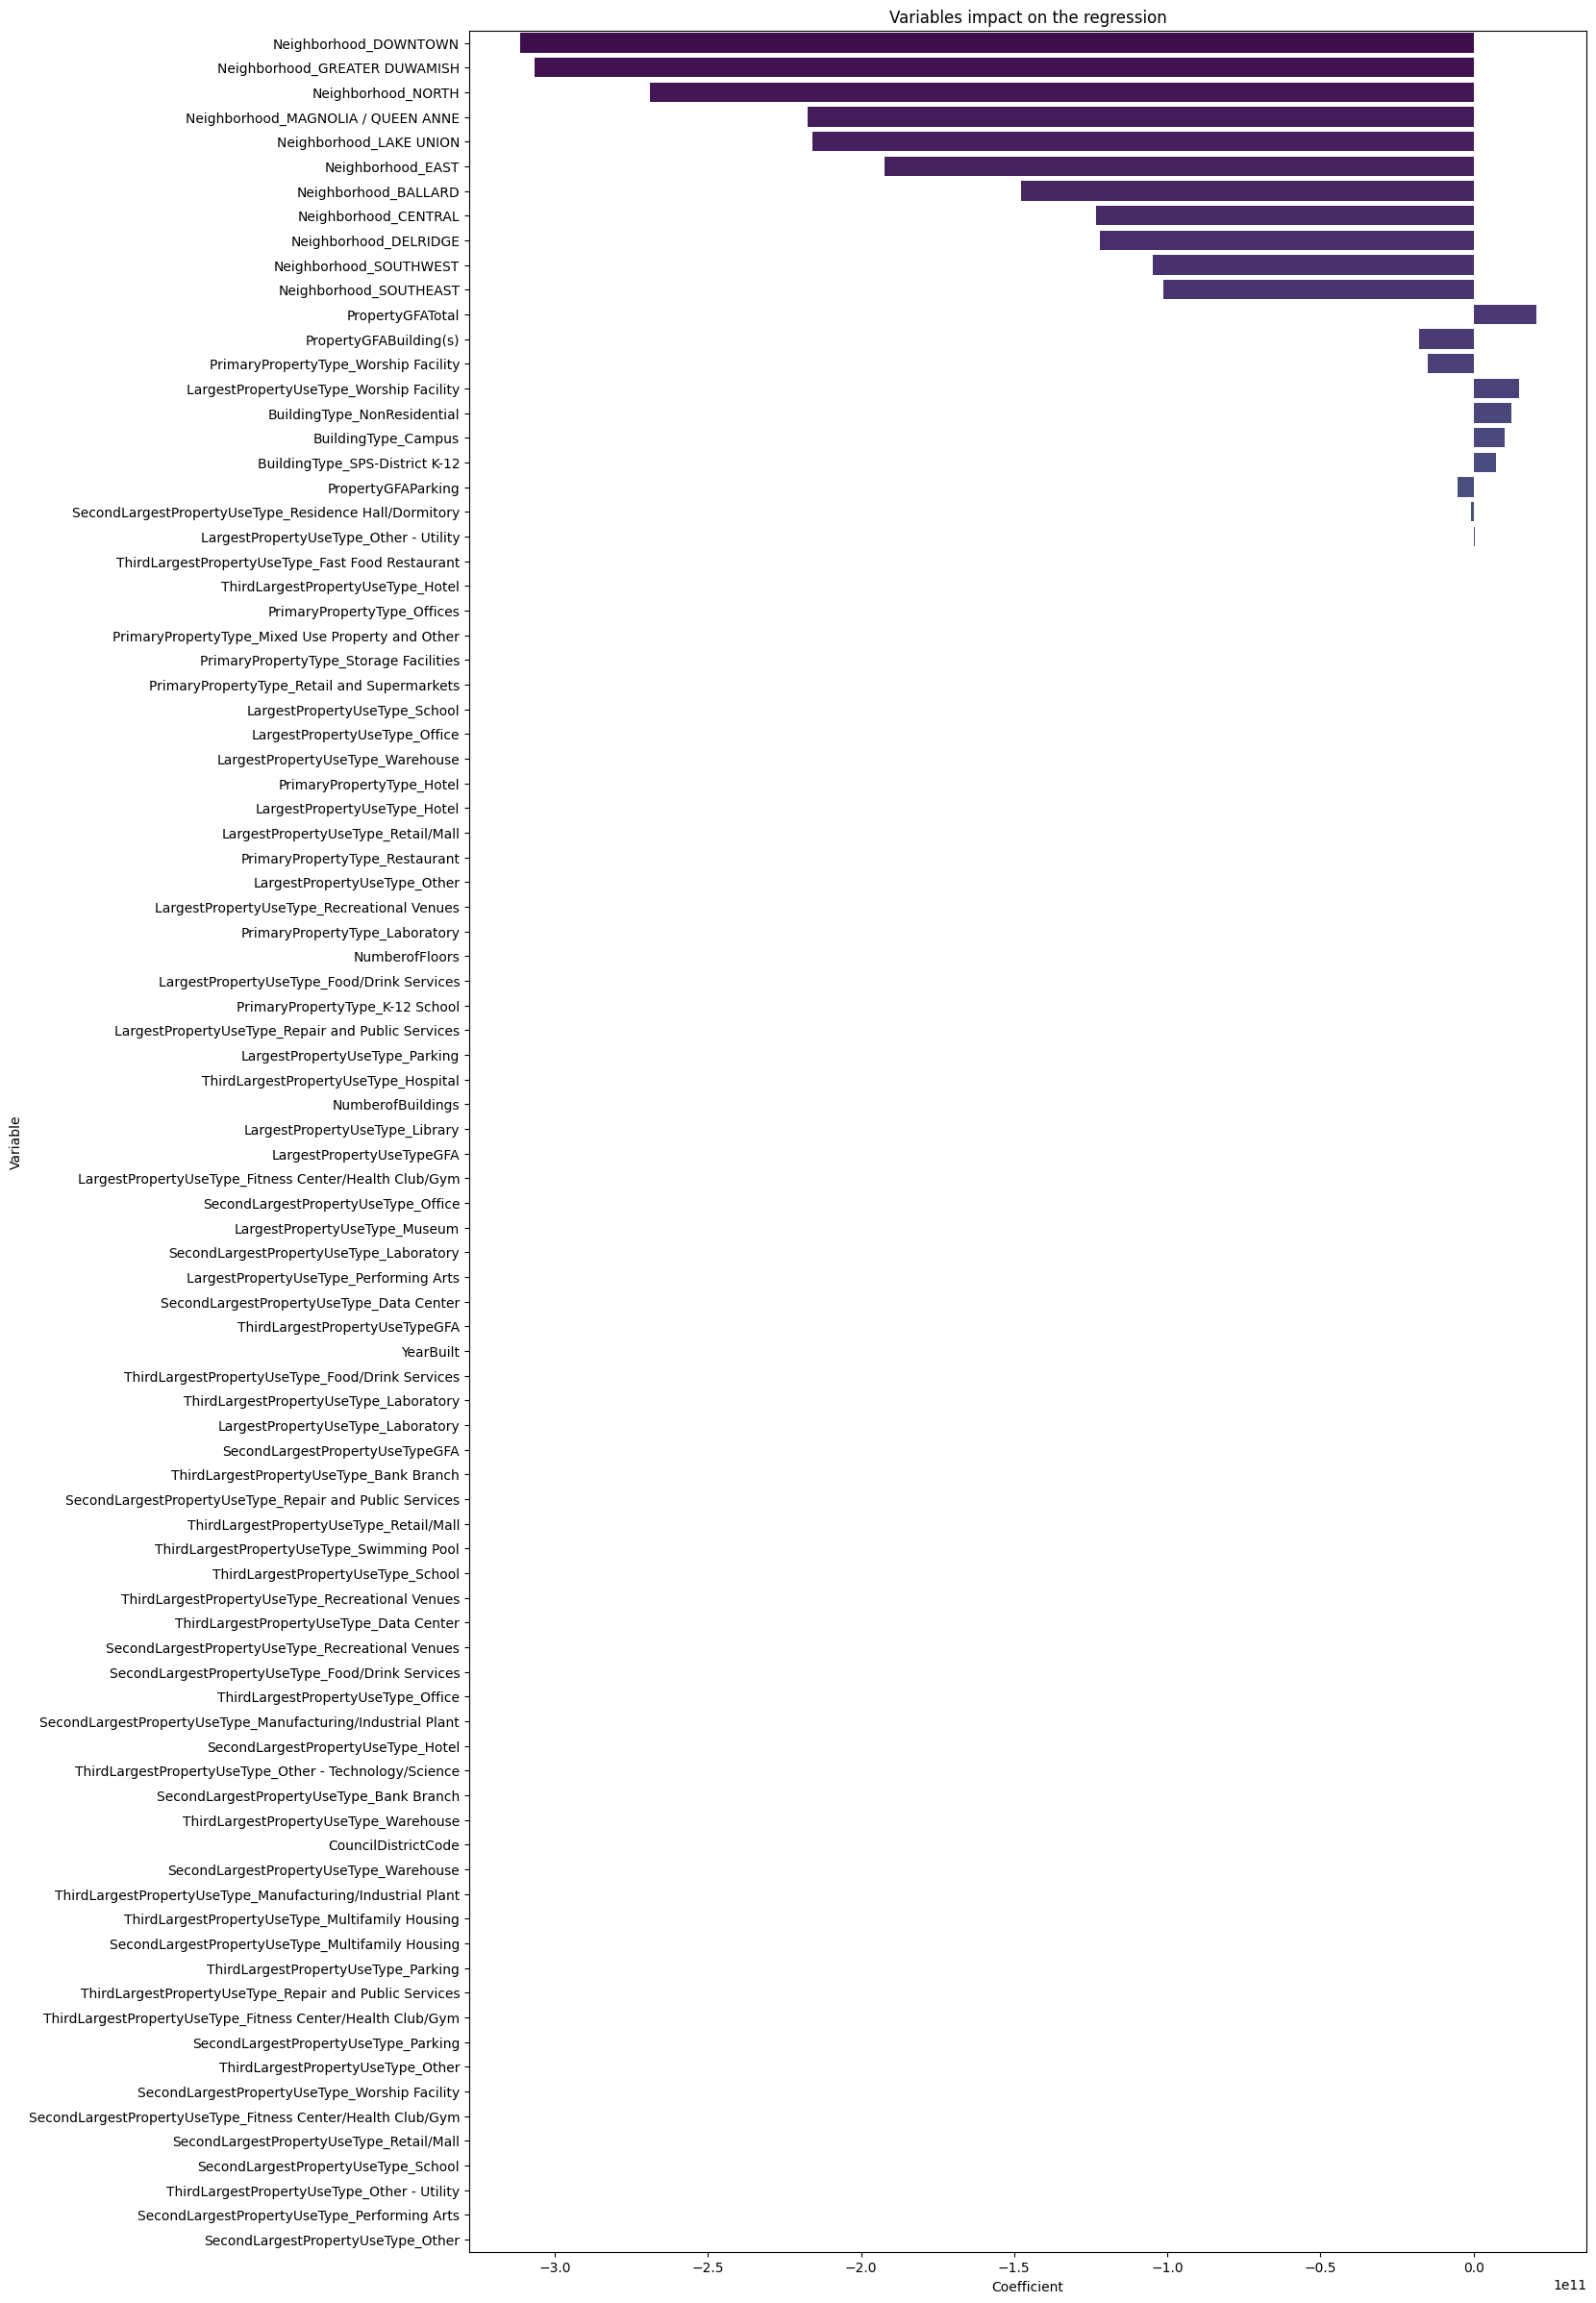

In [19]:
#Create a dataframle from the feature_coefficient tuple
df_coefficients = pd.DataFrame(feature_coefficients, columns=['Feature', 'Coefficient'])

# Sorting the dataframe by feature importance
df_coefficients_sorted = df_coefficients.reindex(df_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Create the plot
plt.figure(figsize=(15, 30))
sns.barplot(x='Coefficient', y='Feature', data=df_coefficients_sorted, palette='viridis')
plt.title('Variables impact on the regression')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

Very few variables seem to have an impact on the regression

- Neighborhood_DOWNTOWN: 473969379331.1985
- Neighborhood_GREATER DUWAMISH: 466860439529.8844
- Neighborhood_NORTH: 409524655582.1725
- Neighborhood_MAGNOLIA / QUEEN ANNE: 330835900323.2003
- Neighborhood_LAKE UNION: 328709867040.0459
- PropertyGFATotal: 311334418081.2454
- Neighborhood_EAST: 292775736003.5324
- PropertyGFABuilding(s): -269506191096.3441
- Neighborhood_BALLARD: 224739522181.83307
- BuildingType_NonResidential: 208712314223.8195
- Neighborhood_CENTRAL: 187729924170.80368
- Neighborhood_DELRIDGE: 185546196972.89236
- BuildingType_Campus: 171000726066.5945
- Neighborhood_SOUTHWEST: 159322752914.7445
- Neighborhood_SOUTHEAST: 154026737799.68933
- BuildingType_SPS-District K-12: 121330011177.74438
- PropertyGFAParking: -77540282712.57219
- PrimaryPropertyType_Worship Facility: -3602455874.040574
- LargestPropertyUseType_Worship Facility: 3602455873.255768

### 3.1.3 Main variables, location and and main property types variables

I will now try to reduce the number of variables sicne it seems that most of them are not useful to the model.

I will keep basic information about the buildings : YearBuilt, NumberofBuildings, NumberofFloors, BuildingType, PrimaryPropertyType
I will keep location information using Council district code and Neighborhood information
I will keep all information about Gross floor areas (GFA) since they give information the size attributed to different parts of the building (parking, hotel...)
Second and Third largest property use don't seem to be interesting and add a lot of columns du to encoding, I will not keep them.

In [20]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [21]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 544 to 1126
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   CouncilDistrictCode                               1033 non-null   float64
 1   YearBuilt                                         1033 non-null   float64
 2   NumberofBuildings                                 1033 non-null   float64
 3   NumberofFloors                                    1033 non-null   float64
 4   PropertyGFATotal                                  1033 non-null   float64
 5   PropertyGFAParking                                1033 non-null   float64
 6   PropertyGFABuilding(s)                            1033 non-null   float64
 7   LargestPropertyUseTypeGFA                         1033 non-null   float64
 8   SecondLargestPropertyUseTypeGFA                   1033 non-null   float64
 9   ThirdLargestPropertyUs

In [23]:
print(y_train.info())

<class 'pandas.core.series.Series'>
Index: 1033 entries, 544 to 1126
Series name: SiteEnergyUse(kBtu)
Non-Null Count  Dtype  
--------------  -----  
1033 non-null   float64
dtypes: float64(1)
memory usage: 16.1 KB
None


In [24]:
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 444 entries, 1233 to 714
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   CouncilDistrictCode                               444 non-null    float64
 1   YearBuilt                                         444 non-null    float64
 2   NumberofBuildings                                 444 non-null    float64
 3   NumberofFloors                                    444 non-null    float64
 4   PropertyGFATotal                                  444 non-null    float64
 5   PropertyGFAParking                                444 non-null    float64
 6   PropertyGFABuilding(s)                            444 non-null    float64
 7   LargestPropertyUseTypeGFA                         444 non-null    float64
 8   SecondLargestPropertyUseTypeGFA                   444 non-null    float64
 9   ThirdLargestPropertyUse

In [25]:
print(y_test.info())

<class 'pandas.core.series.Series'>
Index: 444 entries, 1233 to 714
Series name: SiteEnergyUse(kBtu)
Non-Null Count  Dtype  
--------------  -----  
444 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB
None


### 3.1.4 - 5 Folds Cross Validation

In [26]:
#Initiating the Linear Regression model
model = LinearRegression()

# Finding out how long the model takes
start_time = timeit.default_timer()

#Defining hyperparameters to search
#Testing with fit intercept true and false to see which one gives the best result
param_grid = {
    'fit_intercept': [True, False]
}

#Initiating cross validation search, with 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')

#Use the model and cross validation on the training data 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [27]:
# Function to calculate p-value
def calculate_p_value(y_true, y_pred, dof):
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    mse_res = rss / dof
    mse_model = mean_squared_error(y_true, y_pred)
    f = mse_model / mse_res
    p_value = 1 - stats.f.cdf(f, X_test.shape[1], dof)
    return p_value

#Saving the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the model to predict y, based on X_Test
predictions = best_model.predict(X_test)

# Accessing results of the grid search
results = grid_search.cv_results_
intercepts = results['param_fit_intercept']
mean_squared_errors = -results['mean_test_score']

# Loop through each model's results
for i in range(len(intercepts)):
    # Extracting model parameters
    intercept = intercepts[i]
    mse = mean_squared_errors[i]
    r2 = r2_score(y_test, predictions)
    
    # Calculating p-value
    p_value = calculate_p_value(y_test, predictions, len(y_test) - X_test.shape[1] - 1)

    # Printing results
    print(f"Model {i+1}:")
    print(f"  Fit Intercept: {intercept}")
    print(f"  R2 Score: {r2}")
    print(f"  Mean Squared Error: {mse}")
    print(f"  P-value: {p_value}")

# For the best model
best_intercept = best_model.fit_intercept
best_predictions = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)
best_p_value = calculate_p_value(y_test, best_predictions, len(y_test) - X_test.shape[1] - 1)

# Printing results for the best model
print("Best Model:")
print(f"  Fit Intercept: {best_intercept}")
print(f"  R2 Score: {best_r2}")
print(f"  Mean Squared Error: {best_mse}")
print(f"  P-value: {best_p_value}")

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Model 1:
  Fit Intercept: True
  R2 Score: 0.6059365184195433
  Mean Squared Error: 0.5800788579464363
  P-value: 0.5926505138446819
Model 2:
  Fit Intercept: False
  R2 Score: 0.6059365184195433
  Mean Squared Error: 0.58016437876901
  P-value: 0.5926505138446819
Best Model:
  Fit Intercept: True
  R2 Score: 0.6059365184195433
  Mean Squared Error: 0.437765307474628
  P-value: 0.5926505138446819
Elapsed time : 0.14


The mean squared error is at 0.43 and the coefficient of determination is 0.59, which means that this model is way better than the previous one.

In [28]:
# Accessing the coefficients of the best model
coefficients = best_model.coef_

# Getting the names of the features
feature_names = X.columns

# Associating coefficients with feature names
feature_coefficients = list(zip(feature_names, coefficients))

# Displaying the impact of each variable on the regression
print("\nImpact of each variable on the regression:")
for feature, coefficient in feature_coefficients:
    print(f"{feature}: {coefficient}")


Impact of each variable on the regression:
CouncilDistrictCode: -0.03239187264212422
YearBuilt: 0.05499141237140159
NumberofBuildings: 0.1485749541138994
NumberofFloors: 0.12603780623857427
PropertyGFATotal: 66948631308.77006
PropertyGFAParking: -16674082585.95859
PropertyGFABuilding(s): -57953986373.51
LargestPropertyUseTypeGFA: 0.25619375737198075
SecondLargestPropertyUseTypeGFA: 0.09230533907617014
ThirdLargestPropertyUseTypeGFA: -0.01775344818964012
BuildingType_Campus: 32928496568.175774
BuildingType_NonResidential: 40190371589.302505
BuildingType_SPS-District K-12: 23363730368.758957
PrimaryPropertyType_Hotel: -0.261584251311521
PrimaryPropertyType_K-12 School: -0.24385932668219928
PrimaryPropertyType_Laboratory: -0.024262242028850592
PrimaryPropertyType_Mixed Use Property and Other: -0.43293933431653375
PrimaryPropertyType_Offices: -0.6262167197260636
PrimaryPropertyType_Restaurant: -0.09555855661900636
PrimaryPropertyType_Retail and Supermarkets: -0.3184119495812681
PrimaryPro

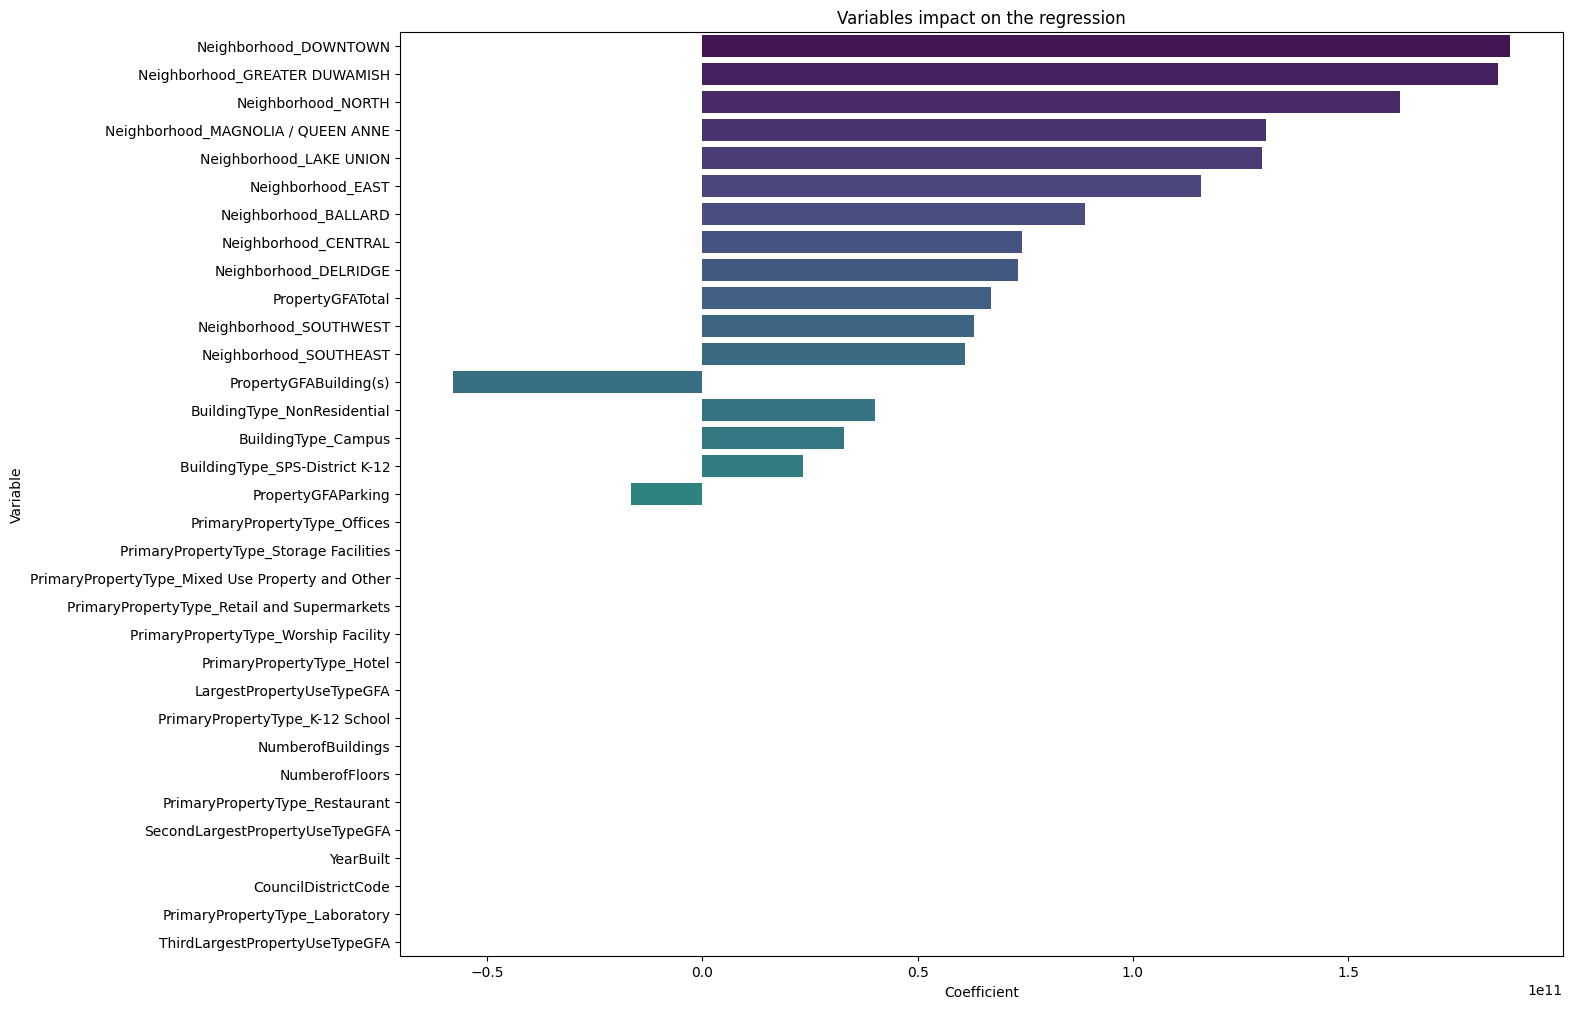

In [29]:
#Create a dataframle from the feature_coefficient tuple
df_coefficients = pd.DataFrame(feature_coefficients, columns=['Feature', 'Coefficient'])

# Sorting the dataframe by feature importance
df_coefficients_sorted = df_coefficients.reindex(df_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Create the plot
plt.figure(figsize=(15, 12))
sns.barplot(x='Coefficient', y='Feature', data=df_coefficients_sorted, palette='viridis')
plt.title('Variables impact on the regression')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

There are still a few variables that the model doesn't indicate as useful.

I will try to see if removing those improves its predictions

### 3.1.5 Trying to remove variables with an impact close to 0

Removing Primary property types with coefficient close to 0: Laboratory, restaurant, storage facility
Removing CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'

In [30]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12','PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School','PrimaryPropertyType_Mixed Use Property and Other','PrimaryPropertyType_Offices',
          'PrimaryPropertyType_Retail and Supermarkets','PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility',
          'Neighborhood_BALLARD','Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [31]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
#Initiating the Linear Regression model
model = LinearRegression()

#Defining hyperparameters to search
#Testing with fit intercept true and false to see which one gives the best result
param_grid = {
    'fit_intercept': [True, False]
}

#Initiating cross validation search, with 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')

#Use the model and cross validation on the training data 
grid_search.fit(X_train, y_train)

# Function to calculate p-value
def calculate_p_value(y_true, y_pred, dof):
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    mse_res = rss / dof
    mse_model = mean_squared_error(y_true, y_pred)
    f = mse_model / mse_res
    p_value = 1 - stats.f.cdf(f, X_test.shape[1], dof)
    return p_value

#Saving the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the model to predict y, based on X_Test
predictions = best_model.predict(X_test)

# Accessing results of the grid search
results = grid_search.cv_results_
intercepts = results['param_fit_intercept']
mean_squared_errors = -results['mean_test_score']

# Loop through each model's results
for i in range(len(intercepts)):
    # Extracting model parameters
    intercept = intercepts[i]
    mse = mean_squared_errors[i]
    r2 = r2_score(y_test, predictions)
    
    # Calculating p-value
    p_value = calculate_p_value(y_test, predictions, len(y_test) - X_test.shape[1] - 1)

    # Printing results
    print(f"Model {i+1}:")
    print(f"  Fit Intercept: {intercept}")
    print(f"  R2 Score: {r2}")
    print(f"  Mean Squared Error: {mse}")
    print(f"  P-value: {p_value}")

# For the best model
best_intercept = best_model.fit_intercept
best_predictions = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)
best_p_value = calculate_p_value(y_test, best_predictions, len(y_test) - X_test.shape[1] - 1)

# Printing results for the best model
print("Best Model:")
print(f"  Fit Intercept: {best_intercept}")
print(f"  R2 Score: {best_r2}")
print(f"  Mean Squared Error: {best_mse}")
print(f"  P-value: {best_p_value}")

Model 1:
  Fit Intercept: True
  R2 Score: 0.5508585242564754
  Mean Squared Error: 0.5562971330952866
  P-value: 0.5416383113184259
Model 2:
  Fit Intercept: False
  R2 Score: 0.5508585242564754
  Mean Squared Error: 0.5565679374217771
  P-value: 0.5416383113184259
Best Model:
  Fit Intercept: True
  R2 Score: 0.5508585242564754
  Mean Squared Error: 0.4989514771576931
  P-value: 0.5416383113184259



Impact of each variable on the regression:
PropertyGFATotal: -422826625660.64966
PropertyGFAParking: 105308292909.38379
PropertyGFABuilding(s): 366019260185.2309
BuildingType_Campus: 2498528197729.81
BuildingType_NonResidential: 3049540281476.5747
BuildingType_SPS-District K-12: 1772778754404.4617
PrimaryPropertyType_Hotel: -0.18308943390010438
PrimaryPropertyType_K-12 School: -0.19996890656195088
PrimaryPropertyType_Mixed Use Property and Other: -0.32403301324930867
PrimaryPropertyType_Offices: -0.4795307333526113
PrimaryPropertyType_Retail and Supermarkets: -0.24586344761526388
PrimaryPropertyType_Storage Facilities: -0.414122521440876
PrimaryPropertyType_Worship Facility: -0.23126907945853503
Neighborhood_BALLARD: 3954605746636.3374
Neighborhood_CENTRAL: 3303370184888.5923
Neighborhood_DELRIDGE: 3264944455215.8623
Neighborhood_DOWNTOWN: 8340153138335.944
Neighborhood_EAST: 5151797942946.885
Neighborhood_GREATER DUWAMISH: 8215061414735.986
Neighborhood_LAKE UNION: 5784109161363.967


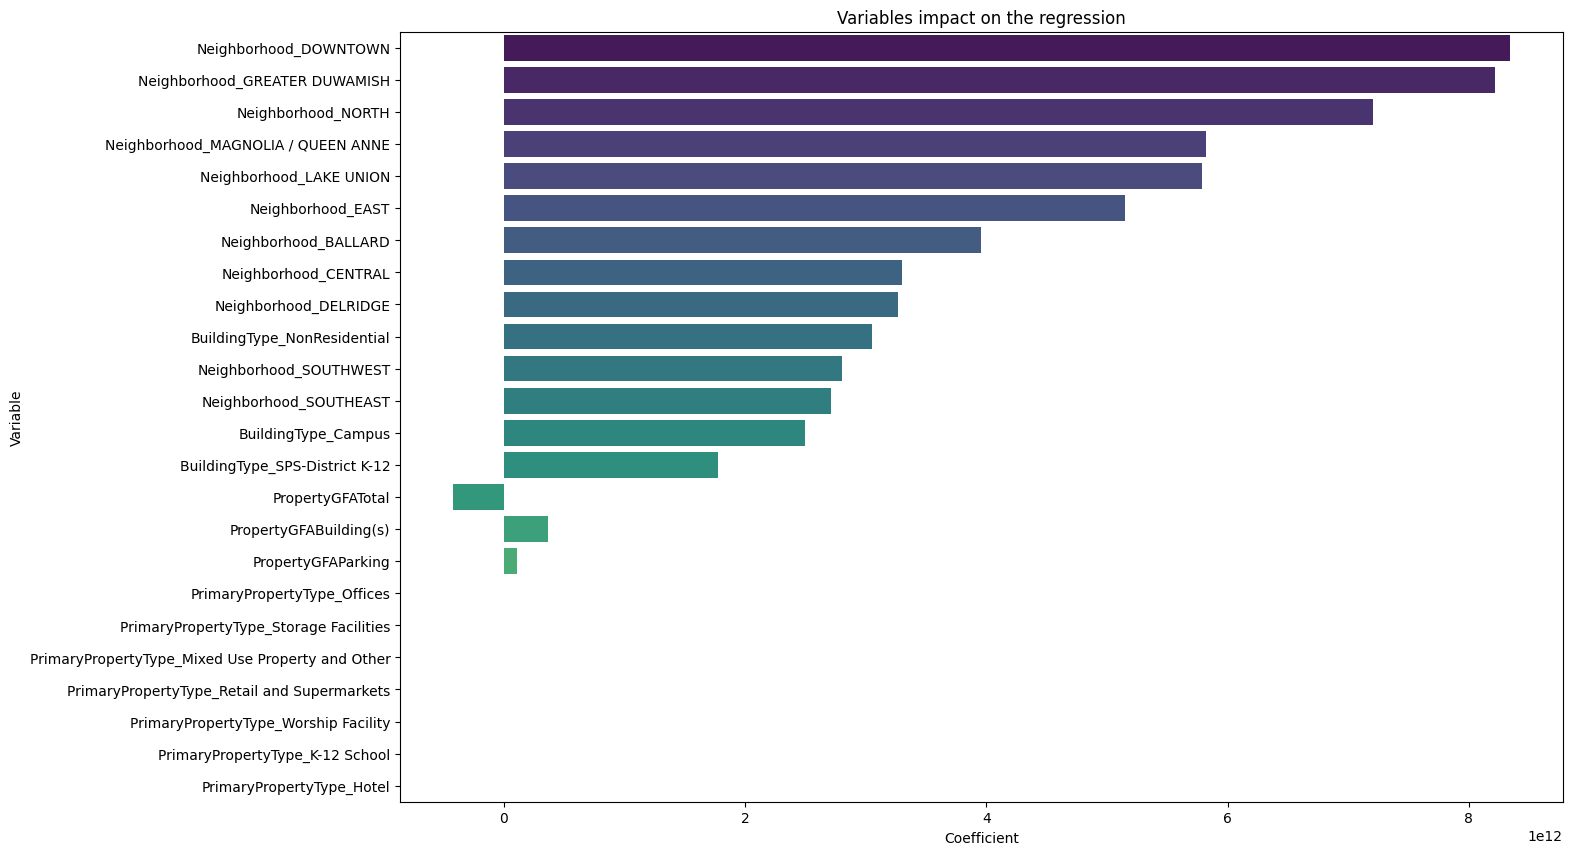

In [33]:
# Accessing the coefficients of the best model
coefficients = best_model.coef_

# Getting the names of the features
feature_names = X.columns

# Associating coefficients with feature names
feature_coefficients = list(zip(feature_names, coefficients))

# Displaying the impact of each variable on the regression
print("\nImpact of each variable on the regression:")
for feature, coefficient in feature_coefficients:
    print(f"{feature}: {coefficient}")


#Create a dataframle from the feature_coefficient tuple
df_coefficients = pd.DataFrame(feature_coefficients, columns=['Feature', 'Coefficient'])

# Sorting the dataframe by feature importance
df_coefficients_sorted = df_coefficients.reindex(df_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Create the plot
plt.figure(figsize=(15, 10))
sns.barplot(x='Coefficient', y='Feature', data=df_coefficients_sorted, palette='viridis')
plt.title('Variables impact on the regression')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

### 3.1.2 - 10 folds cross validation

Using a higher number of folds to see if the model's accuracy improves. Using the X data that yielded the best results with 5 folds.

In [34]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [35]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
#Initiating the Linear Regression model
model = LinearRegression()

#Defining hyperparameters to search
#Testing with fit intercept true and false to see which one gives the best result
param_grid = {
    'fit_intercept': [True, False]
}

#Initiating cross validation search, with 10 folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')

#Use the model and cross validation on the training data 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [37]:
#Saving the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the model to predict y, based on X_Test
predictions = best_model.predict(X_test)

#Evaluate the performances of the best model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error :", mse)

#Calculating the coefficient of determination R2
r_squared = r2_score(y_test, predictions)
print("R2 :",r_squared)

Mean Squared Error : 0.4387258206021293
R2 : 0.6050718926927803


10 folds cross validation gives slightly better results than 5 folds cross validation with the same data (5 folds: 0.59, 10 folds : 0.60)

## 3.2 Lasso Regression

The previous regression gave good results, but it might be interesting to evaluate each variable to see which ones are really useful to the model, it would allow to reduce the number of variables given as input and reduce the calculation ressources needed to make the prediction.

Lasso regression is a regularization model that allows to exclude variables that are actually not useful from the equation, it simplifies the equation by reducing the number of variables taken into account to make the prediction.

In [38]:
#Defining alpha parameter that will determine how much bias is introduced in the line equation.
param_grid = {'alpha': [0.1,0.5,1,5,20,100]}

#Instanciating the lasso model
lasso = Lasso()

#Using cross validation with 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(lasso,param_grid,cv=cv, scoring='neg_mean_squared_error')
#Fitting the grid search to the training data
grid_search.fit(X_train,y_train)

#Finding the best hyperparameter
best_alpha = grid_search.best_params_['alpha']

In [39]:
lasso_best = Lasso(alpha = best_alpha)
lasso_best.fit(X_train,y_train)

Lasso(alpha=0.1)

In [40]:
test_score = lasso_best.score(X_test,y_test)
test_score

0.515326944549642

In [41]:
#Predict value on the test subset
y_pred = lasso_best.predict(X_test)

# Calculating R²
r2 = r2_score(y_test, y_pred)
print("R²:", r2)

R²: 0.515326944549642


In [42]:
# Caculating the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE) :", mse)

Mean Squared Error (MSE) : 0.5384235258058888


When looking at several possible values for alpha, it appears that the lowest value gives the best results.

Increasing alpha leads to reducing the number of variables taken into account during the regression, however it seems that all variables are important since the "classical" linear regression gives better results, and lasso identifies the lowest alpha as the best choice.

The lowest alpha's result are not as good as the results from classical regression. in this case, it seems that sticking to classical regression would be the best choice.

Lasso permet d'amener à 0 l'impact de certaines variables, Evaluer l'importance de chaque variable sur la regression ?

# 4. Random Forest testing - Site Energy Use

Since the values to predict are not categories but continuous values, I need to use Random Forest Regressor.

## All Variables - 1 000 estimators

In [43]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode','YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','BuildingType_Campus',
'BuildingType_NonResidential','BuildingType_SPS-District K-12','PrimaryPropertyType_Hotel','PrimaryPropertyType_K-12 School','PrimaryPropertyType_Laboratory',
'PrimaryPropertyType_Mixed Use Property and Other','PrimaryPropertyType_Offices','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility','Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE',
'Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER DUWAMISH','Neighborhood_LAKE UNION','Neighborhood_MAGNOLIA / QUEEN ANNE','Neighborhood_NORTH',
'Neighborhood_SOUTHEAST','Neighborhood_SOUTHWEST','LargestPropertyUseType_Fitness Center/Health Club/Gym','LargestPropertyUseType_Food/Drink Services',
'LargestPropertyUseType_Hotel','LargestPropertyUseType_Laboratory','LargestPropertyUseType_Library','LargestPropertyUseType_Museum',
'LargestPropertyUseType_Office','LargestPropertyUseType_Other','LargestPropertyUseType_Other - Utility','LargestPropertyUseType_Parking',
'LargestPropertyUseType_Performing Arts','LargestPropertyUseType_Recreational Venues','LargestPropertyUseType_Repair and Public Services',
'LargestPropertyUseType_Retail/Mall','LargestPropertyUseType_School','LargestPropertyUseType_Warehouse','LargestPropertyUseType_Worship Facility',
'SecondLargestPropertyUseType_Bank Branch','SecondLargestPropertyUseType_Data Center','SecondLargestPropertyUseType_Fitness Center/Health Club/Gym',
'SecondLargestPropertyUseType_Food/Drink Services','SecondLargestPropertyUseType_Hotel','SecondLargestPropertyUseType_Laboratory',
'SecondLargestPropertyUseType_Manufacturing/Industrial Plant','SecondLargestPropertyUseType_Multifamily Housing','SecondLargestPropertyUseType_Office',
'SecondLargestPropertyUseType_Other','SecondLargestPropertyUseType_Parking','SecondLargestPropertyUseType_Performing Arts',
'SecondLargestPropertyUseType_Recreational Venues','SecondLargestPropertyUseType_Repair and Public Services',
'SecondLargestPropertyUseType_Residence Hall/Dormitory','SecondLargestPropertyUseType_Retail/Mall','SecondLargestPropertyUseType_School',
'SecondLargestPropertyUseType_Warehouse','SecondLargestPropertyUseType_Worship Facility','ThirdLargestPropertyUseType_Bank Branch',
'ThirdLargestPropertyUseType_Data Center','ThirdLargestPropertyUseType_Fast Food Restaurant','ThirdLargestPropertyUseType_Fitness Center/Health Club/Gym',
'ThirdLargestPropertyUseType_Food/Drink Services','ThirdLargestPropertyUseType_Hospital',
'ThirdLargestPropertyUseType_Hotel','ThirdLargestPropertyUseType_Laboratory','ThirdLargestPropertyUseType_Manufacturing/Industrial Plant',
'ThirdLargestPropertyUseType_Multifamily Housing','ThirdLargestPropertyUseType_Office','ThirdLargestPropertyUseType_Other',
'ThirdLargestPropertyUseType_Other - Technology/Science','ThirdLargestPropertyUseType_Other - Utility','ThirdLargestPropertyUseType_Parking',
'ThirdLargestPropertyUseType_Recreational Venues','ThirdLargestPropertyUseType_Repair and Public Services','ThirdLargestPropertyUseType_Retail/Mall',
'ThirdLargestPropertyUseType_School','ThirdLargestPropertyUseType_Swimming Pool','ThirdLargestPropertyUseType_Warehouse']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [44]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
# Initiating the model
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fitting it to the data
model = rfr.fit(X_train, y_train)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Evaluating the model on the test set
predictions = rfr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Cross-Validation Mean Squared Error: 0.50 ± 0.36
Test Set Mean Squared Error: 0.44
R-squared: 0.60
Elapsed time : 37.96


Feature Importances:
PropertyGFABuilding(s): 0.2449
LargestPropertyUseTypeGFA: 0.2181
PropertyGFATotal: 0.1818
NumberofBuildings: 0.0641
SecondLargestPropertyUseType_Office: 0.0579
NumberofFloors: 0.0390
YearBuilt: 0.0224
CouncilDistrictCode: 0.0189
SecondLargestPropertyUseTypeGFA: 0.0168
Neighborhood_NORTH: 0.0160
PrimaryPropertyType_Mixed Use Property and Other: 0.0158
SecondLargestPropertyUseType_Data Center: 0.0075
ThirdLargestPropertyUseTypeGFA: 0.0074
LargestPropertyUseType_Office: 0.0070
LargestPropertyUseType_Other: 0.0064
BuildingType_NonResidential: 0.0060
Neighborhood_DOWNTOWN: 0.0053
SecondLargestPropertyUseType_Parking: 0.0049
PropertyGFAParking: 0.0048
LargestPropertyUseType_Food/Drink Services: 0.0043
Neighborhood_CENTRAL: 0.0043
PrimaryPropertyType_Offices: 0.0035
BuildingType_Campus: 0.0034
Neighborhood_EAST: 0.0033
LargestPropertyUseType_Laboratory: 0.0031
PrimaryPropertyType_Laboratory: 0.0031
LargestPropertyUseType_Recreational Venues: 0.0029
LargestPropertyUseType_

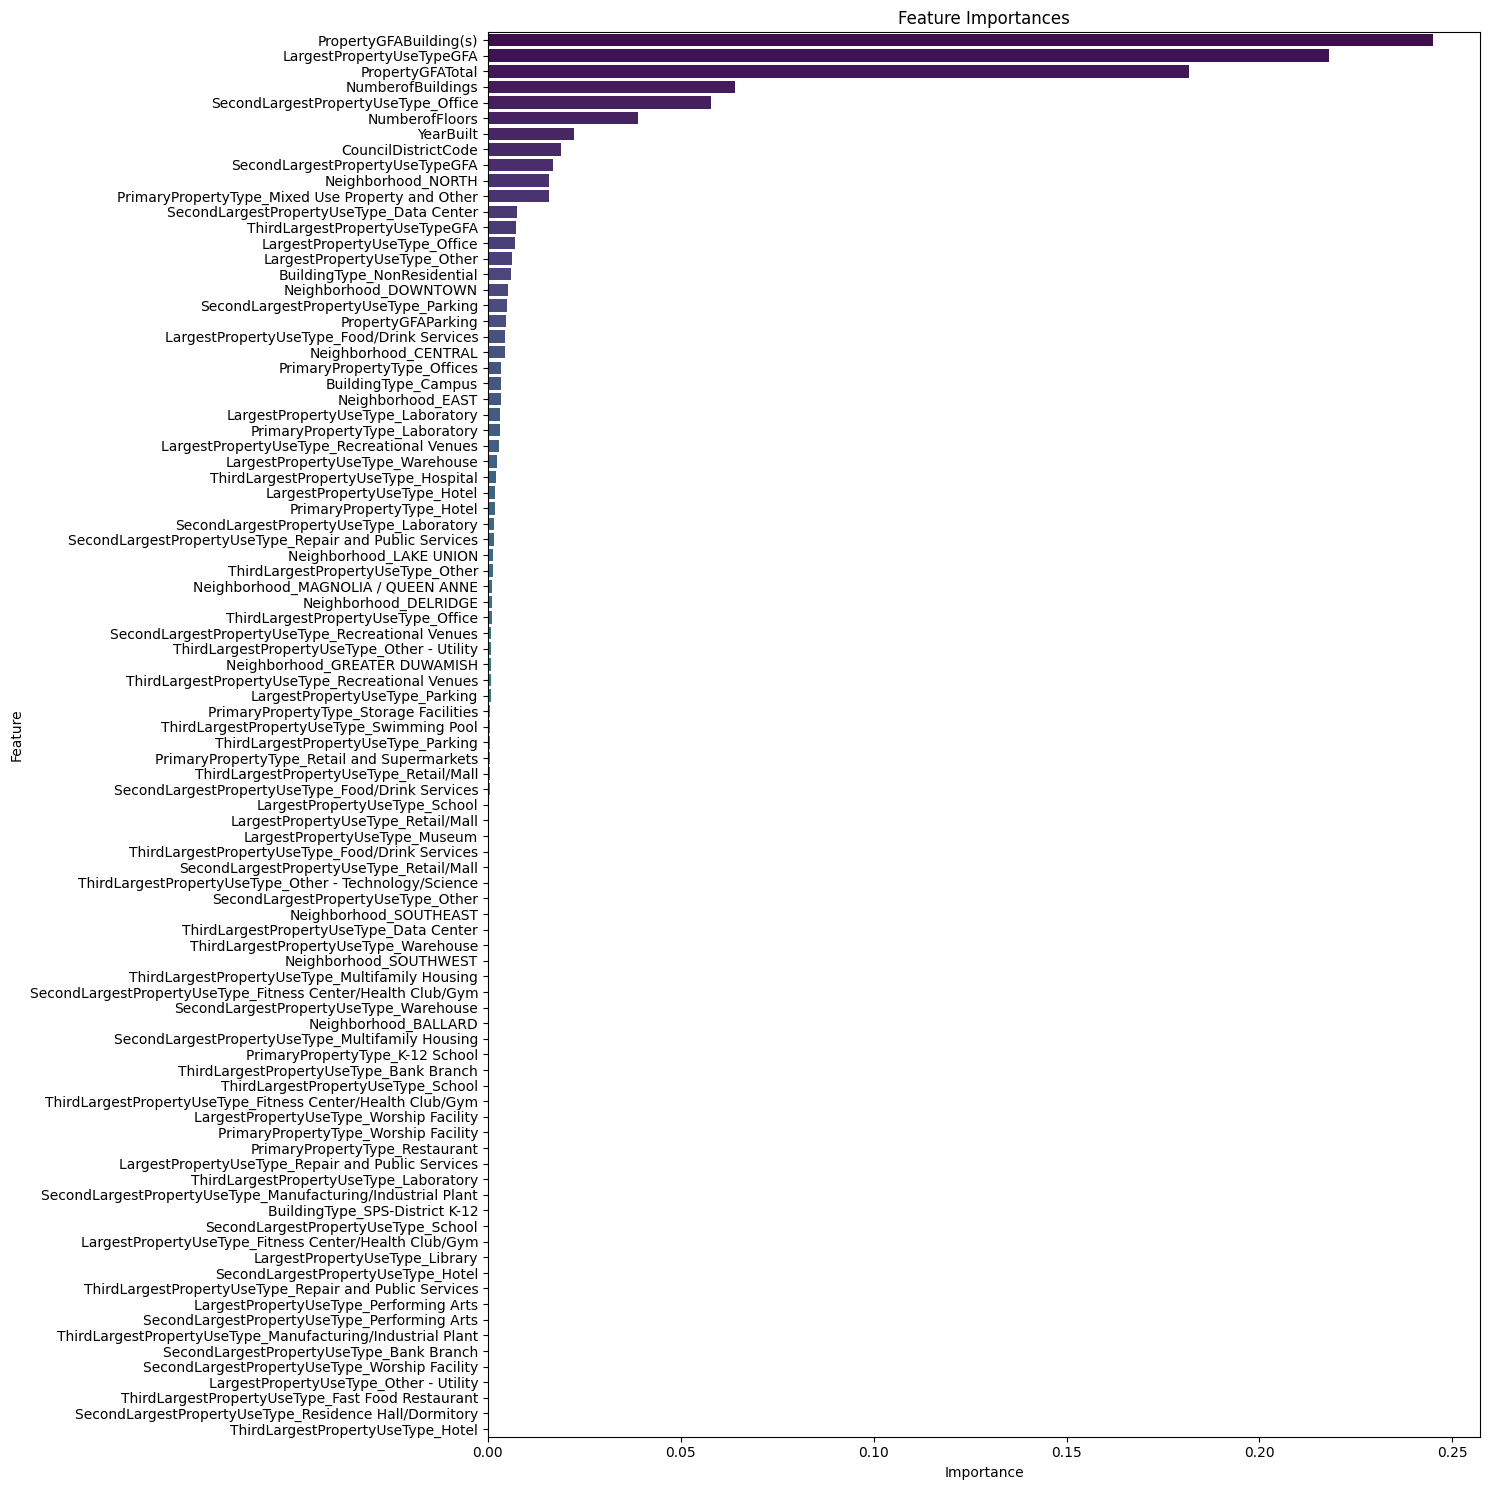

In [46]:
# Feature importances
importances = model.feature_importances_

# Indices of features sorted by importance in descending order
indices = np.argsort(importances)[::-1]

# Feature names
feature_names = X_train.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': feature_names[indices],
    'Importance': importances[indices]
})


# Print feature importances
print("Feature Importances:")
for i in range(X_train.shape[1]):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot with Seaborn
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

## Selected variables

In [47]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [48]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 4.1 - 1 000 estimators

I will start by creating a random forest regressor model with all variables included and look at its performance (MSE and R2). I will not define any hyperparameters and therefore use scikit learn default values for all parameters.

In [49]:
# Initiating the model
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fitting it to the data
model = rfr.fit(X_train, y_train)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Evaluating the model on the test set
predictions = rfr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Cross-Validation Mean Squared Error: 0.52 ± 0.35
Test Set Mean Squared Error: 0.44
R-squared: 0.61
Elapsed time : 29.47


### 4.1.1 Feature importances

Feature Importances:
LargestPropertyUseTypeGFA: 0.2701
PropertyGFABuilding(s): 0.2544
PropertyGFATotal: 0.1890
NumberofBuildings: 0.0674
NumberofFloors: 0.0418
YearBuilt: 0.0261
SecondLargestPropertyUseTypeGFA: 0.0239
PrimaryPropertyType_Mixed Use Property and Other: 0.0213
CouncilDistrictCode: 0.0201
Neighborhood_NORTH: 0.0162
ThirdLargestPropertyUseTypeGFA: 0.0105
PropertyGFAParking: 0.0068
PrimaryPropertyType_Offices: 0.0067
Neighborhood_DOWNTOWN: 0.0057
BuildingType_Campus: 0.0056
BuildingType_NonResidential: 0.0054
PrimaryPropertyType_Laboratory: 0.0052
Neighborhood_EAST: 0.0045
Neighborhood_CENTRAL: 0.0041
PrimaryPropertyType_Hotel: 0.0036
PrimaryPropertyType_Storage Facilities: 0.0029
Neighborhood_LAKE UNION: 0.0023
PrimaryPropertyType_Retail and Supermarkets: 0.0023
Neighborhood_MAGNOLIA / QUEEN ANNE: 0.0012
Neighborhood_GREATER DUWAMISH: 0.0011
Neighborhood_DELRIDGE: 0.0010
Neighborhood_SOUTHEAST: 0.0003
Neighborhood_SOUTHWEST: 0.0002
PrimaryPropertyType_Restaurant: 0.0002
Nei

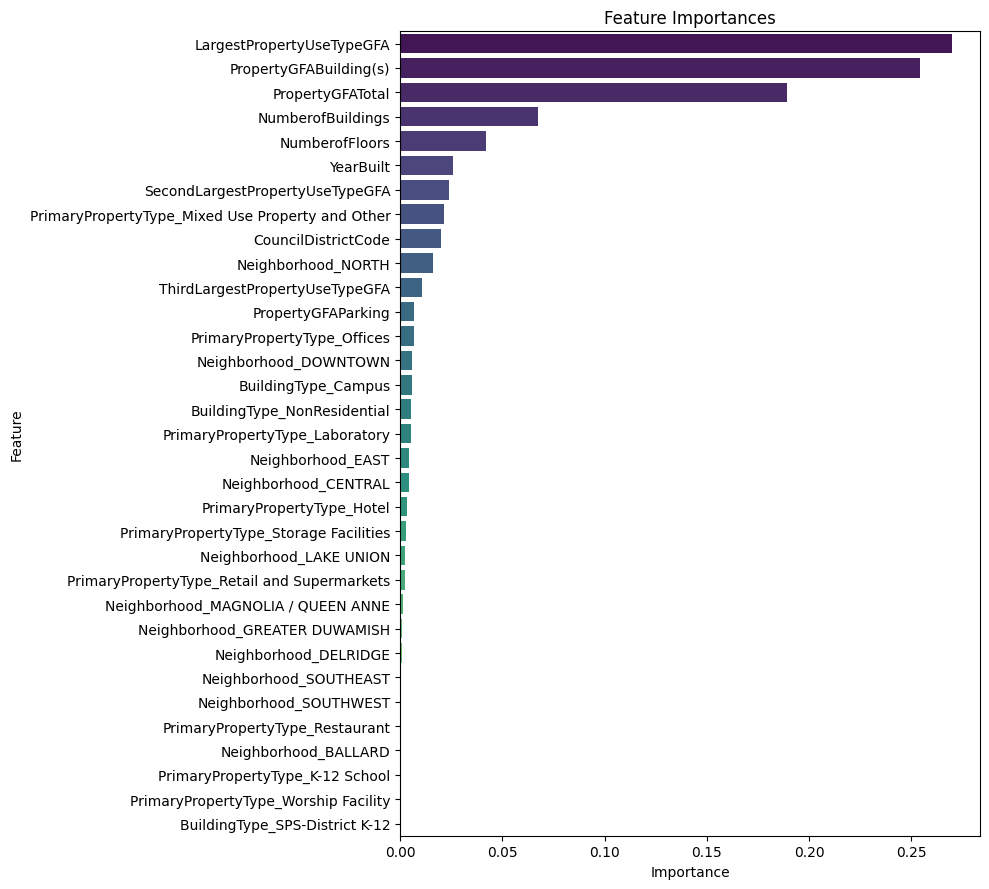

In [50]:
# Feature importances
importances = model.feature_importances_

# Indices of features sorted by importance in descending order
indices = np.argsort(importances)[::-1]

# Feature names
feature_names = X_train.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': feature_names[indices],
    'Importance': importances[indices]
})


# Print feature importances
print("Feature Importances:")
for i in range(X_train.shape[1]):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot with Seaborn
plt.figure(figsize=(10, 9))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

## 4.2 Variables/Features selection 

To see if the model can be improved, I will try several thresholds.

A threshold will select variables based on their importance to make a good prediction. The variables importance goes from 0 to 1, a threshold at 0.5 will select variables that have at least a 0.5 importance in the model's prediction.

#### 4.2.1 - Threshold at 0.05

In [51]:
# Initiating the model
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fitting it to the data
model = rfr.fit(X_train, y_train)

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr, prefit=True, threshold=0.05)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Refitting the model on the entire training set with selected features
best_model = rfr.fit(X_train2, y_train)

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 4)
Cross-Validation Mean Squared Error: 0.60 ± 0.38
Test Set Mean Squared Error: 0.40
R-squared: 0.64
Elapsed time : 17.51


With a threshold of 0,05, 4 variables are kept to make the prediction

This model's performances are higher than the previous one's.

#### Feature importances

Feature Importances:
NumberofBuildings: 0.1001
PropertyGFATotal: 0.2502
PropertyGFABuilding(s): 0.3026
LargestPropertyUseTypeGFA: 0.3471


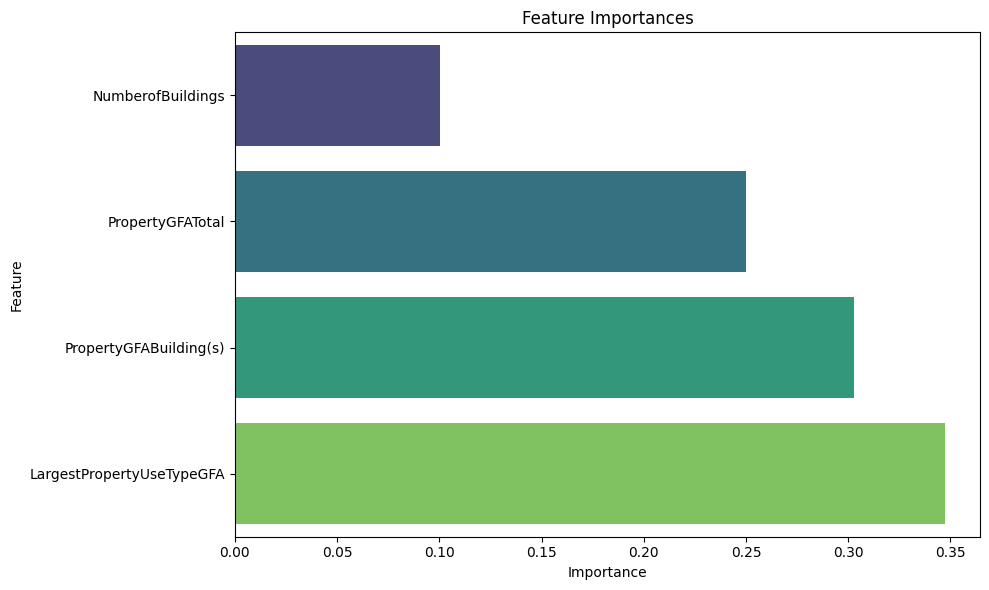

In [52]:
# Feature importances for the selected features
importances = best_model.feature_importances_

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
})

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(selected_feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

### 4.4.2 - Threshold at 0.005

In [53]:
# Initiating the model
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fitting it to the data
model = rfr.fit(X_train, y_train)

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr, prefit=True, threshold=0.005)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Refitting the model on the entire training set with selected features
best_model = rfr.fit(X_train2, y_train)

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Mixed Use Property and Other',
       'PrimaryPropertyType_Offices', 'Neighborhood_DOWNTOWN',
       'Neighborhood_NORTH'],
      dtype='object') (1033, 17)
Cross-Validation Mean Squared Error: 0.52 ± 0.35
Test Set Mean Squared Error: 0.45
R-squared: 0.60
Elapsed time : 29.79


With a threshold of 0.005, 17 variables are kept to make the prediction

### Feature importances

Feature Importances:
CouncilDistrictCode: 0.0250
YearBuilt: 0.0279
NumberofBuildings: 0.0674
NumberofFloors: 0.0439
PropertyGFATotal: 0.1951
PropertyGFAParking: 0.0078
PropertyGFABuilding(s): 0.2515
LargestPropertyUseTypeGFA: 0.2750
SecondLargestPropertyUseTypeGFA: 0.0236
ThirdLargestPropertyUseTypeGFA: 0.0111
BuildingType_Campus: 0.0057
BuildingType_NonResidential: 0.0056
PrimaryPropertyType_Laboratory: 0.0055
PrimaryPropertyType_Mixed Use Property and Other: 0.0234
PrimaryPropertyType_Offices: 0.0078
Neighborhood_DOWNTOWN: 0.0061
Neighborhood_NORTH: 0.0177


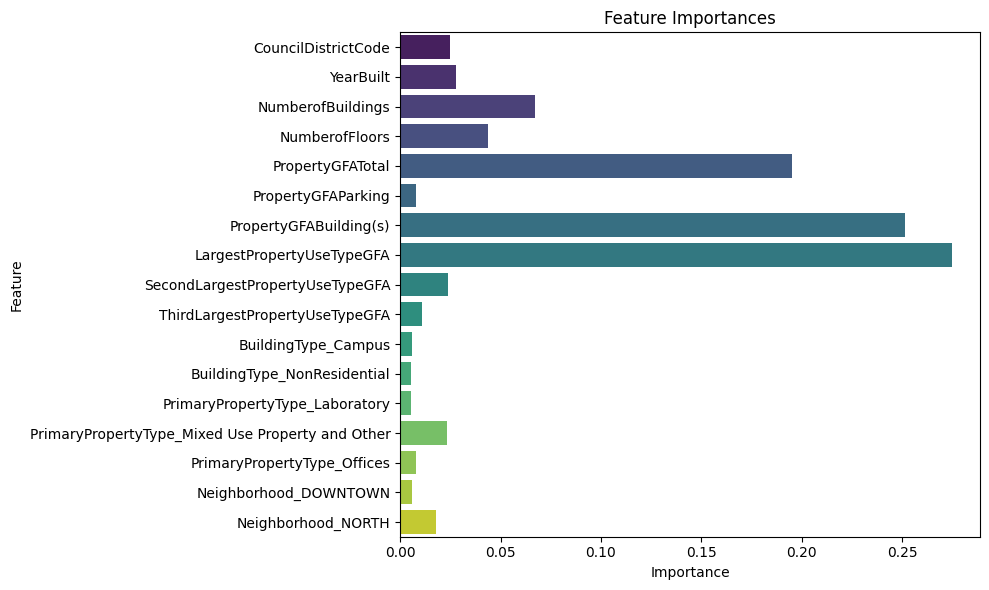

In [54]:
# Feature importances for the selected features
importances = best_model.feature_importances_

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
})

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(selected_feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

### 4.2.3 - Threshold at 0.003

In [55]:
# Initiating the model
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fitting it to the data
model = rfr.fit(X_train, y_train)

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr, prefit=True, threshold=0.003)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Refitting the model on the entire training set with selected features
best_model = rfr.fit(X_train2, y_train)

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Mixed Use Property and Other',
       'PrimaryPropertyType_Offices', 'Neighborhood_CENTRAL',
       'Neighborhood_DOWNTOWN', 'Neighborhood_EAST', 'Neighborhood_NORTH'],
      dtype='object') (1033, 20)
Cross-Validation Mean Squared Error: 0.52 ± 0.36
Test Set Mean Squared Error: 0.44
R-squared: 0.60
Elapsed time : 30.90


With a threshold of 0.0003, 27 variables are kept to make the prediction

For now, the best performances are given by models that contain the largest number of variables. Which makes sense since we lose less information by taking all variables (or most of them) into account.

### Feature importances

Feature Importances:
CouncilDistrictCode: 0.0222
YearBuilt: 0.0258
NumberofBuildings: 0.0668
NumberofFloors: 0.0428
PropertyGFATotal: 0.1938
PropertyGFAParking: 0.0072
PropertyGFABuilding(s): 0.2550
LargestPropertyUseTypeGFA: 0.2732
SecondLargestPropertyUseTypeGFA: 0.0224
ThirdLargestPropertyUseTypeGFA: 0.0105
BuildingType_Campus: 0.0060
BuildingType_NonResidential: 0.0057
PrimaryPropertyType_Hotel: 0.0039
PrimaryPropertyType_Laboratory: 0.0055
PrimaryPropertyType_Mixed Use Property and Other: 0.0210
PrimaryPropertyType_Offices: 0.0072
Neighborhood_CENTRAL: 0.0044
Neighborhood_DOWNTOWN: 0.0058
Neighborhood_EAST: 0.0046
Neighborhood_NORTH: 0.0161


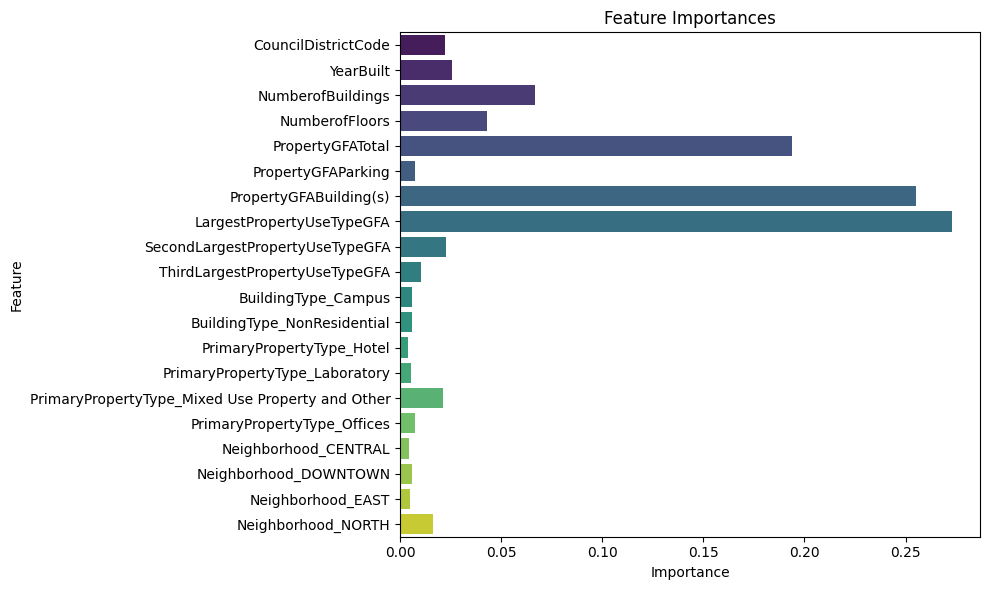

In [56]:
# Feature importances for the selected features
importances = best_model.feature_importances_

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
})

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(selected_feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

### 4.2.4 - 500 estimators

In [57]:
# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Fitting it to the data
model = rfr.fit(X_train, y_train)

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr, prefit=True, threshold=0.05)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Refitting the model on the entire training set with selected features
best_model = rfr.fit(X_train2, y_train)

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 4)
Cross-Validation Mean Squared Error: 0.60 ± 0.38
Test Set Mean Squared Error: 0.40
R-squared: 0.64
Elapsed time : 9.09


It seems that 500 estimators with default parameters and a threshold at 0.05 gives the best results.

Using less estimators (numbers of trees in the forest) is better since it will take fewer time to compute.

#### 500 estimators with 10 folds cross validation

Since 10 fold cross validation worked a little better with linear regression, I will try it with random forest

In [58]:
# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Fitting it to the data
model = rfr.fit(X_train, y_train)

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr, prefit=True, threshold=0.05)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Refitting the model on the entire training set with selected features
best_model = rfr.fit(X_train2, y_train)

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 4)
Cross-Validation Mean Squared Error: 0.65 ± 0.59
Test Set Mean Squared Error: 0.40
R-squared: 0.64
Elapsed time : 17.15


Same results with 10 folds cross validation, longer time to compute.

I will try to see if it is possible to improve the results by trying several possibility for the hyperparameters.

Trying with randomized search to improve the model's performances.

While grid search tries every single possibilities, Randomized search will select a number possibilities within the given hyperparameters and select the best model given by these possibilities.

## 4.3 Grid search

In [59]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [60]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Initiating the model
rfr = RandomForestRegressor(random_state = 42)

#Fitting it to the data
model = rfr.fit(X_train, y_train)

#Features selection, selecting variable with an importance supérior to 0.05
select = SelectFromModel(rfr, prefit = True, threshold = 0.05)

X_train3 = select.transform(X_train)

#Transforming X_test to get the same number of variables than X_train
X_test3 = select.transform(X_test)


# Hyperparameters to test
param_grid = {
    'n_estimators': [200,500,600],  # Number of trees in the forest
    'max_depth': [None,1,2,3,10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'random_state' : [42]
}


# Instantiating the grid search and cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='neg_mean_squared_error', cv =cv)

#Traning the model on the new X_train with grid search
grid_search.fit(X_train3, y_train)

# Display the best parameters
print("Best parameters:")
print(grid_search.best_params_)

# Create a variable containing the best model
best_model = grid_search.best_estimator_

# Use the best model to make predictions
predictions = best_model.predict(X_test3)

#Displaying the time spent
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

# Evaluate the best model's performances
mse = mean_squared_error(y_test, predictions)
print("Best model Mean Squared Error (MSE) : {:.2f}".format(mse))

r2 = r2_score(y_test, predictions)
print("Best model R-squared : {:.2f}".format(r2))

Best parameters:
{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}
Elapsed time : 436.25
Best model Mean Squared Error (MSE) : 0.55
Best model R-squared : 0.50


## 4.4 Randomized search

In [62]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [63]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Initiating the model
rfr = RandomForestRegressor(random_state = 42)

#Fitting it to the data
model = rfr.fit(X_train, y_train)

#Features selection, selecting variable with an importance supérior to 0.05
select = SelectFromModel(rfr, prefit = True, threshold = 0.05)

X_train3 = select.transform(X_train)

#Transforming X_test to get the same number of variables than X_train
X_test3 = select.transform(X_test)


# Hyperparameters to test
param_distributions = {
    'n_estimators': [200,500,600,700],  # Number of trees in the forest
    'max_depth': randint(1,10),  # Maximum depth of each tree
    'min_samples_split': randint(2,12),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1,5),  # Minimum number of samples required to be at a leaf node
    'random_state' : [42]
}


# Instantiating the grid search and cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_distributions,n_iter=300, scoring='neg_mean_squared_error', cv = cv)

#Traning the model on the new X_train with grid search
random_search.fit(X_train3, y_train)

# Display the best parameters
print("Best parameters:")
print(random_search.best_params_)

# Create a variable containing the best model
best_model = random_search.best_estimator_

# Use the best model to make predictions
predictions = best_model.predict(X_test3)

#Displaying the time spent
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

# Evaluate the best model's performances
mse = mean_squared_error(y_test, predictions)
print("Best model Mean Squared Error (MSE) : {:.2f}".format(mse))

r2 = r2_score(y_test, predictions)
print("Best model R-squared : {:.2f}".format(r2))

Best parameters:
{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 500, 'random_state': 42}
Elapsed time : 1134.13
Best model Mean Squared Error (MSE) : 0.55
Best model R-squared : 0.50


## 4.5 Random search with None in max_depth

In [65]:
# Fonction personnalisée pour inclure None dans la distribution
def custom_distribution():
    values = [None] + list(range(1, 11))
    return values

# Initiating the model
rfr_none = RandomForestRegressor(random_state=42)

# Fitting it to the data
model = rfr_none.fit(X_train, y_train)

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr_none, prefit=True, threshold=0.05)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

# Hyperparameters to test
param_distributions = {
    'n_estimators': [200, 500, 600, 1000],  # Number of trees in the forest
    'max_depth': custom_distribution(),  # Include None in max_depth
    'min_samples_split': randint(2, 12),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 5),  # Minimum number of samples required to be at a leaf node
    'random_state': [42]
}

# Instantiating the random search and cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=rfr_none, param_distributions=param_distributions, n_iter=300, scoring='neg_mean_squared_error', cv=cv, random_state=42)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform the random search on the new X_train with selected features
random_search.fit(X_train2, y_train)

# Display the best parameters
print("Best parameters:")
print(random_search.best_params_)

# Create a variable containing the best model
best_model = random_search.best_estimator_

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))


Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 4)
Best parameters:
{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 500, 'random_state': 42}
Test Set Mean Squared Error: 0.55
R-squared: 0.50
Elapsed time : 1335.55


# 4.6 Summary

1000 estimators - All variables - No Threshold
Cross-Validation Mean Squared Error: 0.52 ± 0.35
Test Set Mean Squared Error: 0.44
R-squared: 0.61
Elapsed time : 43.12

1000 estimators - 4 variables - Threshold at 0.05
Cross-Validation Mean Squared Error: 0.60 ± 0.38
Test Set Mean Squared Error: 0.40
R-squared: 0.64
Elapsed time : 25.95

1000 estimators - 17 variables - Threshold at 0.005
Cross-Validation Mean Squared Error: 0.52 ± 0.35
Test Set Mean Squared Error: 0.45
R-squared: 0.60
Elapsed time : 43.05

1000 estimators - 20 variables - Threshold at 0.003
Cross-Validation Mean Squared Error: 0.52 ± 0.36
Test Set Mean Squared Error: 0.44
R-squared: 0.60
Elapsed time : 37.82

500 estimators 4 variables - Threshold at 0.05 - 5 folds cross validation
Cross-Validation Mean Squared Error: 0.60 ± 0.38
Test Set Mean Squared Error: 0.40
R-squared: 0.64
Elapsed time : 12.99

500 estimators 4 variables - Threshold at 0.05 - 10 folds cross validation
Cross-Validation Mean Squared Error: 0.65 ± 0.59
Test Set Mean Squared Error: 0.40
R-squared: 0.64
Elapsed time : 18.99

Grid Search 4 variables - Threshold at 0.05
Best parameters:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}
Elapsed time : 613.00
Best model Mean Squared Error (MSE) : 0.45
Best model R-squared : 0.60

Randomized Search  4 variables - Threshold at 0.05
Best parameters:
{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 700, 'random_state': 42}
Elapsed time : 1431.87
Best model Mean Squared Error (MSE) : 0.58
Best model R-squared : 0.48

Randomized Search  4 variables - Threshold at 0.05
Best parameters:
{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}
Test Set Mean Squared Error: 0.58
R-squared: 0.48
Elapsed time : 1589.26

The best random forest model seems to be with 500 estimators and default values regarding hyperparameters.

## 4.7 With LargestPropertyUseType categories

Adding the LargestPropertyType variables to see if it improves the model's performance. 

LargestPropertyTypeGFA was already added, but it might be interesting to see if the kind of largest property type can improve the the model's prediction.

In [66]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA','BuildingType_Campus','BuildingType_NonResidential',
          'BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel','PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
          'PrimaryPropertyType_Mixed Use Property and Other','PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant',
          'PrimaryPropertyType_Retail and Supermarkets','PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility',
          'Neighborhood_BALLARD','Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION','Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST', 'LargestPropertyUseType_Fitness Center/Health Club/Gym',
          'LargestPropertyUseType_Food/Drink Services','LargestPropertyUseType_Hotel', 'LargestPropertyUseType_Laboratory',
          'LargestPropertyUseType_Library', 'LargestPropertyUseType_Museum','LargestPropertyUseType_Office',
          'LargestPropertyUseType_Other','LargestPropertyUseType_Other - Utility','LargestPropertyUseType_Parking',
          'LargestPropertyUseType_Performing Arts','LargestPropertyUseType_Recreational Venues',
          'LargestPropertyUseType_Repair and Public Services','LargestPropertyUseType_Retail/Mall', 
          'LargestPropertyUseType_School','LargestPropertyUseType_Warehouse','LargestPropertyUseType_Worship Facility']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [68]:
X_train.shape

(1033, 50)

### 4.7.1 - 1 000 estimators

In [69]:
# Initiating the model
rfr_new = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fitting it to the data
model = rfr_new.fit(X_train, y_train)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr_new, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Evaluating the model on the test set
predictions = rfr_new.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Cross-Validation Mean Squared Error: 0.52 ± 0.36
Test Set Mean Squared Error: 0.43
R-squared: 0.61
Elapsed time : 30.09


Performances are the same than with 1000 estimators without the LargestPropertyType

## 4.7.2 - 500 estimators

In [70]:
# Initiating the model
rfr_new2 = RandomForestRegressor(n_estimators=500, random_state=42)

# Fitting it to the data
model = rfr_new2.fit(X_train, y_train)

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr_new2, prefit=True, threshold=0.05)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr_new2, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Refitting the model on the entire training set with selected features
best_model = rfr_new2.fit(X_train2, y_train)

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 4)
Cross-Validation Mean Squared Error: 0.60 ± 0.38
Test Set Mean Squared Error: 0.40
R-squared: 0.64
Elapsed time : 8.76


Conclure sur les performances après avoir ajouté la variable encodée

# 5. Gradient Boosting testing - Site Energy Use

Trying Gradient Boosting Regressor to evaluate if it gives better predictions than Random Forest

## 5.1 With LargestPropertyUseTypeGFA but not the categories

In [71]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [72]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [73]:
#Initiating the model
model = GradientBoostingRegressor()

#Finding out how long the model takes
start_time = timeit.default_timer()

#Defining the cross validation parameters
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Defining a variety of possibility for the model parameters
param_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.4, 0.7)
}

#Looking for the best parameters using cross validation and 120 iterations
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=120, cv=kf, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

#Obtaining the best parameters
best_params = random_search.best_params_

In [74]:
#Training the model with the best parameters
best_model = GradientBoostingRegressor(**best_params)
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.13849434248203232, max_depth=6,
                          n_estimators=83, subsample=0.5678511514101823)

In [75]:
predictions = best_model.predict(X_test)

In [76]:
#Looking at the model best parameters

print("Best parameters:")
print(grid_search.best_params_)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, predictions)
print("R2 : {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Best parameters:
{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}
Mean Squared Error: 0.42436342445393743
R2 : 0.62
Elapsed time : 146.64


In [77]:
#Taking a look at variables with that are the most important in the model
feature_importances = best_model.feature_importances_

#Associating each variable name with its importance
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

In [78]:
sorted_features

[('LargestPropertyUseTypeGFA', 0.26317761668509054),
 ('PropertyGFABuilding(s)', 0.25557825884234314),
 ('PropertyGFATotal', 0.11370647803454612),
 ('NumberofBuildings', 0.09599822948314016),
 ('SecondLargestPropertyUseTypeGFA', 0.05168335020561083),
 ('NumberofFloors', 0.041004458261587426),
 ('PrimaryPropertyType_Mixed Use Property and Other', 0.03676935508455062),
 ('CouncilDistrictCode', 0.03146522034268975),
 ('YearBuilt', 0.01963912699835346),
 ('ThirdLargestPropertyUseTypeGFA', 0.014837994086977122),
 ('BuildingType_NonResidential', 0.013022766013624194),
 ('PropertyGFAParking', 0.009066772783352831),
 ('PrimaryPropertyType_Offices', 0.007667784568870487),
 ('Neighborhood_EAST', 0.006531046087430933),
 ('PrimaryPropertyType_Laboratory', 0.006170031374114299),
 ('PrimaryPropertyType_Hotel', 0.005940193590444778),
 ('Neighborhood_NORTH', 0.005543048609752045),
 ('Neighborhood_DOWNTOWN', 0.004962812159547261),
 ('BuildingType_Campus', 0.004475472815171136),
 ('Neighborhood_LAKE UNI

## 5.2 Threshold at 0.05

In [79]:
# Initiating the model
gbr2 = GradientBoostingRegressor()

# Fitting it to the data
model = gbr2.fit(X_train, y_train)

#Finding out how long the model takes
start_time = timeit.default_timer()


#Defining a variety of possibility for the model parameters
param_grid = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.4, 0.7)
}

#Defining the cross validation parameters
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(gbr2, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(gbr2, prefit=True, threshold=0.05)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]


# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

#Displaying the selected features
print(selected_feature_names, X_train2.shape)


#Looking for the best parameters using cross validation and 120 iterations
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=130, cv=cv, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train2, y_train)

# Create a variable containing the best model
best_model = random_search.best_estimator_

# Display the best parameters
print("Best parameters:")
print(random_search.best_params_)

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))


Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA',
       'PrimaryPropertyType_Mixed Use Property and Other'],
      dtype='object') (1033, 5)
Best parameters:
{'learning_rate': 0.019915219870164515, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 102, 'subsample': 0.7426169321942941}
Cross-Validation Mean Squared Error: 0.73 ± 0.43
Test Set Mean Squared Error: 0.42
R-squared: 0.62
Elapsed time : 210.66


# 6. SVR

Since this is not a classification issue, I can't use support vector machine to try to predict a building's energy consumption. I will use a variation called support vector regression.

In [80]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

In [81]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 6.1 RBF

RBF Kernel : Gaussian Radial Basis Function

In [82]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Defining hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

#Initiating the SVR model
svr = SVR(kernel='rbf')

#Cross Validation and GridSearchCV initiation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svr, param_grid, cv=cv, scoring='neg_mean_squared_error')

#GridSearch
grid_search.fit(X_train, y_train)

#Displaying the best parameters and the score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

#Using the best model to make prediction on the test set
best_svr = grid_search.best_estimator_
predictions = best_svr.predict(X_test)

#Model's evaluation
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Best Parameters: {'C': 10, 'epsilon': 0.1}
Best Score: -0.5863634400392439
Mean Squared Error: 0.6678648887174223
R2 Score: 0.3988076287004879
Elapsed time : 4.58


## 6.2 Poly

In [83]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Defining hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

#Initiating the SVR model
svr = SVR(kernel='poly')

#Cross Validation and GridSearchCV initiation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svr, param_grid, cv=cv, scoring='neg_mean_squared_error')

#GridSearchCV
grid_search.fit(X_train, y_train)

#Displaying the best parameters and the score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

#Using the best model to make prediction on the test set
best_svr = grid_search.best_estimator_
predictions = best_svr.predict(X_test)

#Model's evaluation
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Best Parameters: {'C': 10, 'epsilon': 0.1}
Best Score: -0.6728826758272803
Mean Squared Error: 1.011562864339251
R2 Score: 0.08942079842147477
Elapsed time : 5.99


## 6.3 Sigmoid

In [84]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Defining hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

#Initiating the SVR model
svr = SVR(kernel='sigmoid')

#Cross validation and Grid search initiation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svr, param_grid, cv=cv, scoring='neg_mean_squared_error')

#GridSearch
grid_search.fit(X_train, y_train)

#Displaying the best parameters and the score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

#Using the best model to make prediction on the test set
best_svr = grid_search.best_estimator_
predictions = best_svr.predict(X_test)

#Model's evaluation
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Best Parameters: {'C': 0.1, 'epsilon': 0.5}
Best Score: -0.6527108668902765
Mean Squared Error: 0.8504516609667034
R2 Score: 0.23444837515854355
Elapsed time : 3.78


## 6.4 Linear SVR

In [85]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Defining hyperparameters to search
param_grid_linear_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

#Initiating the model
linear_svr = LinearSVR(random_state=42)

# Cross Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)


# GridSearchCV
grid_search_linear_svr = GridSearchCV(linear_svr, param_grid_linear_svr, cv=cv, scoring='neg_mean_squared_error')
grid_search_linear_svr.fit(X_train, y_train)

# Displaying the best parameters and the score
print(f"LinearSVR - Best Parameters: {grid_search_linear_svr.best_params_}")
print(f"LinearSVR - Best Score: {grid_search_linear_svr.best_score_}")

#Using the best model to make prediction on the test set
best_linear_svr = grid_search_linear_svr.best_estimator_
predictions_linear_svr = best_linear_svr.predict(X_test)

#Model's evaluation
mse_linear_svr = mean_squared_error(y_test, predictions_linear_svr)
r2_linear_svr = r2_score(y_test, predictions_linear_svr)

print(f"LinearSVR - Mean Squared Error: {mse_linear_svr}")
print(f"LinearSVR - R2 Score: {r2_linear_svr}")

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

LinearSVR - Best Parameters: {'C': 1, 'epsilon': 0.2}
LinearSVR - Best Score: -0.5648320311156272
LinearSVR - Mean Squared Error: 0.5212246757815753
LinearSVR - R2 Score: 0.5308088445632788
Elapsed time : 4.43


# 7. SHAP

Using the SHAP method to explain the random forest regressor's predictions, global and local features importances.

Since the best performance (R2 and MSE) was given by 500 estimators, random forest regressor (rfr) with a threshold of 0.05 (4 variables), I will use the shap method on this model.

NumberofBuildings
PropertyGFATotal
PropertyGFABuilding(s)
LargestPropertyUseTypeGFA

Cross-validated scores: [-0.46166367 -0.65479987 -0.32256519 -0.26425151 -1.30256485]
Average cross-validated score: -0.6011690184684428


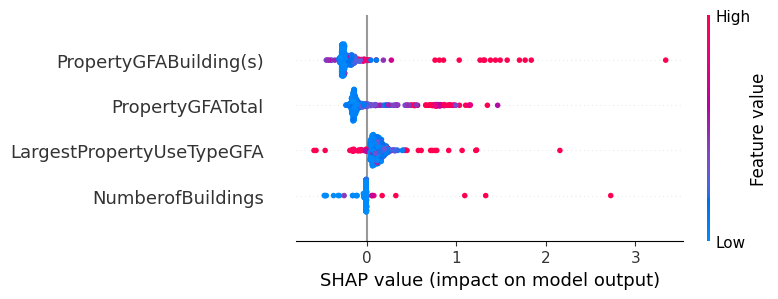

In [7]:
# Creating a dataframe that only contains the 4 features needed by the rfr
X = data[['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA']]

# Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

# Defining parameters for the test train split, using 70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print(f'Cross-validated scores: {cv_scores}')
print(f'Average cross-validated score: {cv_scores.mean()}')

# Fitting the model to the entire training data
rfr.fit(X_train, y_train)

# SHAP

# Initialising the JavaScript visualizations
shap.initjs()

# Initialising SHAP explainer
explainer = shap.TreeExplainer(rfr)

# Calculating SHAP values
shap_values = explainer.shap_values(X_test)

# Visualising global feature importances
shap.summary_plot(shap_values, X_test)

In [8]:
# Visualising local feature importances for the first 5 lines
for i in range(10):
    display(shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i]))

## 7.1 Associating results with the building types

Using the same function to keep the same treatments, but keeping the building's name (PropertyName) and ListOfAllPropertyUseTypes

In [1]:
def all_treatments_2(df):
    #Deleting non residential buildings
    df = df.loc[df['BuildingType'].str.contains("NonResidential|Nonresidential COS|SPS-District K-12|Campus|Nonresidential WA")]
    #Deleting the Residence Halls
    df = df.loc[df['PrimaryPropertyType'] != 'Residence Hall']
    #Deleting Senior Care Community
    df = df.loc[df['PrimaryPropertyType'] != 'Senior Care Community']
    #Deleting Low-Rise Multifamily
    df = df.loc[df['PrimaryPropertyType'] != 'Low-Rise Multifamily']
    #Dropping unecessary columns
    df = df.drop(columns = ['OSEBuildingID','DataYear','Comments','City','State','TaxParcelIdentificationNumber'])
    #Turning 0s into 1 for the number of buildings
    df.loc[df['NumberofBuildings'] == 0, ['NumberofBuildings']] = 1
    #Deleting properties above 30 buildings
    df = df.loc[df['NumberofBuildings'] < 30]
    #Deleting the chinese baptist church
    df = df.loc[df['PropertyName'] != 'Seattle Chinese Baptist Church']
    
    #Deleting outliers in LargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Entire Campus']
    df = df.loc[df['PropertyName'] != 'Columbia Center - 2015']
    df = df.loc[df['PropertyName'] != 'Swedish First Hill']
    df = df.loc[df['PropertyName'] != 'CenturyLink']

    #Deleting outliers in SecondLargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Washington State Convention Center']
    df = df.loc[df['PropertyName'] != 'Plant 2 Site']

    #Deleting outliers in ThirdLargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Russell Investments Center']
    
    #Deleting wheather normalized variables
    df = df.drop(columns = ['SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)'])

    #Deleting buildings with default data
    df = df.loc[df['DefaultData'] == False]
    #Deleting non compliant buildings
    df = df.loc[df['ComplianceStatus'] == 'Compliant']
        
    #Grouping neighborhoods based on their names
    #Turning Nort into NORTH
    df.loc[df['Neighborhood'].str.contains('NORTH|North'), 'Neighborhood'] = 'NORTH'
    #Turning Delridge into DELRIDGE
    df.loc[df['Neighborhood'].str.contains('DELRIDGE|DELRIDGE NEIGHBORHOODS|Delridge'), 'Neighborhood'] = 'DELRIDGE'
    #Ballard into BALLARD
    df.loc[df['Neighborhood'].str.contains('BALLARD|Ballard'), 'Neighborhood'] = 'BALLARD'
    #Northwest into NORTHWEST
    df.loc[df['Neighborhood'].str.contains('NORTHWEST|Northwest'), 'Neighborhood'] = 'NORTHWEST'
    #Central into CENTRAL
    df.loc[df['Neighborhood'].str.contains('CENTRAL|Central'), 'Neighborhood'] = 'CENTRAL'
    #Turning all non residential buildings into the same label 'NonResidential'
    df.loc[df['BuildingType'].str.contains('Nonresidential COS|Nonresidential WA'), ['BuildingType']] = 'NonResidential'
    
    #Grouping primary property types
    new_value = 'Offices'
    new_value_2 = 'Mixed Use Property and Other'
    new_value_3 = 'Retail and Supermarkets'
    new_value_4 = 'Storage Facilities'
    
    #Grouping all kind of offices
    df.loc[df['PrimaryPropertyType'].str.contains('Small- and Mid-Sized Office|Large Office|Medical Office'),
                  'PrimaryPropertyType'] = new_value
    
    #Grouping all mixed used properties and other
    df.loc[df['PrimaryPropertyType'].str.contains('Mixed Use Property|Other'),'PrimaryPropertyType'] = new_value_2
    
    #Grouping retail stores and supermarket, although alimentation stores might use more energy, there are both stores
    df.loc[df['PrimaryPropertyType'].str.contains('Retail Store|Supermarket / Grocery Store'),'PrimaryPropertyType'] = new_value_3
    
    #Grouping self storage facility and warehouses and distribution center. They all consist in a storage for various goods
    df.loc[df['PrimaryPropertyType'].str.contains('Self-Storage Facility|Warehouse|Distribution Center'),
                  'PrimaryPropertyType'] = new_value_4

    #LargestPropertyUseType Treatments
    #Turning all values in LargestPropertyUseType into strings
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].astype(str)

    #Deleting building with a residential largest Property Type 
    df = df.loc[~df['LargestPropertyUseType'].str.contains("Other - Lodging/Residential|Multifamily Housing|Residence Hall/Dormitory|Residential Care Facility")]
    
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'

    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].replace(replacement_mapping)

    #SecondLargestPropertyUseType Treatments
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'
    
    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Vocational School' : Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Convenience Store without Gas Station' : Largest_value_6,
        'Food Sales' : Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Enclosed Mall' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Bar/Nightclub' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].replace(replacement_mapping)

    #ThirdLargestPropertyUseType Treatments
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'
    
    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Vocational School' : Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Convenience Store without Gas Station' : Largest_value_6,
        'Food Sales' : Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Enclosed Mall' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Bar/Nightclub' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].replace(replacement_mapping)
    
    #Unecessary columns deletion
    df = df.drop(columns = ['Outlier','ComplianceStatus','Address','YearsENERGYSTARCertified',
                                                      'DefaultData','Electricity(kWh)','Latitude','Longitude','NaturalGas(therms)','ZipCode'])


    #LargestPropertyUseType treatments
    #Deleting the lines where LargestPropertyUseType is empty
    df = df.loc[ ~ df['LargestPropertyUseType'].str.contains("nan")]

    #SecondLargestPropertyUseType
    #Replacing nans in SecondLargestPropertyUseType with "No_Second_Type"
    df.loc[df['SecondLargestPropertyUseType'].isna(), ['SecondLargestPropertyUseType']] = "No_Second_Type"
    #Replacing nans in SecondLargestPropertyUseTypeGFA with 0
    df.loc[df['SecondLargestPropertyUseTypeGFA'].isna(), ['SecondLargestPropertyUseTypeGFA']] = 0

    #ThirdLargestPropertyUseType
    #Replacing nans in ThirdLargestPropertyUseType with "No_Third_Type"
    df.loc[df['ThirdLargestPropertyUseType'].isna(), ['ThirdLargestPropertyUseType']] = "No_Third_Type"
    #Replacing nans in ThirdLargestPropertyUseTypeGFA with 0
    df.loc[df['ThirdLargestPropertyUseTypeGFA'].isna(), ['ThirdLargestPropertyUseTypeGFA']] = 0

    
    #Using KNN to impute EnergyStar Score
    imputer = KNNImputer(n_neighbors = 3, weights = 'uniform')
    #Creating a dataset with numerical columns only to use the KNNs
    knn_data = df.loc[:,['YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','ENERGYSTARScore','SiteEUI(kBtu/sf)',
    'SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity']]
    #Fit and transform the dataset with the imputer, turning it into a pandas dataframe
    knn_imputed = pd.DataFrame(imputer.fit_transform(knn_data))
    #Giving the same columns names
    knn_imputed.columns = knn_data.columns
    
    #Resetting data with missing index
    df = df.reset_index()
    #Dropping new index column 
    df = df.drop(columns = ['index'])
    
    #Replacing initial energystar column with the imputed column
    df['ENERGYSTARScore'] = knn_imputed.ENERGYSTARScore

    #Creating a dataframe with the energystar score
    df_with_energy = df.drop(columns = ['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','GHGEmissionsIntensity'])
    
    return df_with_energy

In [4]:
entire_data = pd.read_csv("Building_Energy_Benchmarking.csv")

transformed_data_2 = all_treatments_2(entire_data)

In [5]:
#Looking at the first 10 buildings to see if what kind of buildings are the 2nd, and 9th buildings
transformed_data_2[['PrimaryPropertyType','PropertyName','NumberofBuildings','PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA']].head(10)

,PrimaryPropertyType,PropertyName,NumberofBuildings,PropertyGFATotal,PropertyGFABuilding(s),LargestPropertyUseTypeGFA
0,Hotel,Mayflower park hotel,1.0,88434,88434,88434.0
1,Hotel,Paramount Hotel,1.0,103566,88502,83880.0
2,Hotel,5673-The Westin Seattle,1.0,956110,759392,756493.0
3,Hotel,HOTEL MAX,1.0,61320,61320,61320.0
4,Hotel,WARWICK SEATTLE HOTEL (ID8),1.0,175580,113580,123445.0
5,Mixed Use Property and Other,West Precinct,1.0,97288,60090,88830.0
6,Hotel,Camlin,1.0,83008,83008,81352.0
7,Mixed Use Property and Other,Paramount Theatre,1.0,102761,102761,102761.0
8,Hotel,311wh-Pioneer Square,1.0,163984,163984,163984.0
9,Hotel,Hotel Monaco Seattle,1.0,153163,133884,133884.0


# 8. Energy Star Score

## 8.1 Random Forest

In [6]:
# Creating a dataframe that only contains the 4 features needed by the rfr
X = data[['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','ENERGYSTARScore']]

# Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

# Defining parameters for the test train split, using 70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Finding out how long the model takes
start_time = timeit.default_timer()

# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Fitting it to the data
rfr.fit(X_train, y_train)

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print(f'Cross-validated scores: {cv_scores}')
print(f'Average cross-validated score: {cv_scores.mean()}')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Evaluating the model on the test set
predictions = rfr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Cross-validated scores: [-0.42022711 -0.55913811 -0.23962579 -0.15928021 -1.26168081]
Average cross-validated score: -0.5279904053144227
Cross-Validation Mean Squared Error: 0.53 ± 0.39
Test Set Mean Squared Error: 0.47
R-squared: 0.58
Elapsed time : 11.57


### 8.1.1 Energy star score feature importance

Cross-validated scores: [-0.42022711 -0.55913811 -0.23962579 -0.15928021 -1.26168081]
Average cross-validated score: -0.5279904053144227


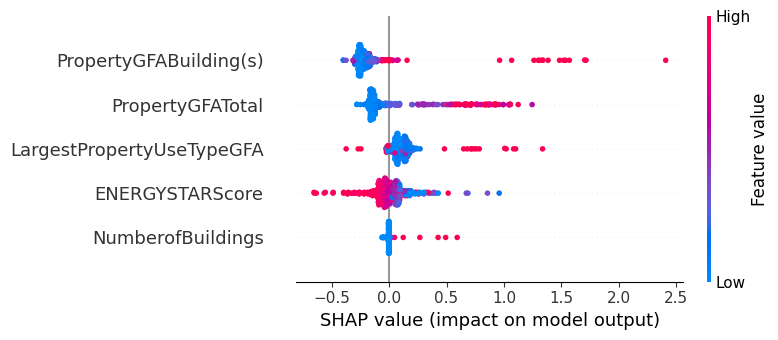

In [7]:
# Creating a dataframe that only contains the 4 features needed by the rfr
X = data[['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','ENERGYSTARScore']]

# Using Site Energy Use to define y, the target
y = data['SiteEnergyUse(kBtu)']

# Defining parameters for the test train split, using 70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print(f'Cross-validated scores: {cv_scores}')
print(f'Average cross-validated score: {cv_scores.mean()}')

# Fitting the model to the entire training data
rfr.fit(X_train, y_train)

# SHAP

# Initialising the JavaScript visualizations
shap.initjs()

# Initialising SHAP explainer
explainer = shap.TreeExplainer(rfr)

# Calculating SHAP values
shap_values = explainer.shap_values(X_test)

# Visualising global feature importances
shap.summary_plot(shap_values, X_test)

In [8]:
# Visualising local feature importances for the first 5 lines
for i in range(10):
    display(shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i]))

## 8.2 Energy Star Score (with no missing values replacement)

Since I have replaced missing values in the energy star score, it is possible that the fact that the energy star score doesn't improve the model is due to the values replacement (528 missing values on 1477 lines).

I will try to remove the lines where I replaced EnergyStarScore(ESS) missing values, run the model and look at the ESS influence again.

Since the best model is random forest, and it doesn't need the data to be standardised, I will not use the second function (that uses standard scaler to standardise the data).

The second function also encodes categorical values, however, I don't use categorical values in the final model.

In [2]:
def all_treatments_3(df):
    #Deleting non residential buildings
    df = df.loc[df['BuildingType'].str.contains("NonResidential|Nonresidential COS|SPS-District K-12|Campus|Nonresidential WA")]
    #Deleting the Residence Halls
    df = df.loc[df['PrimaryPropertyType'] != 'Residence Hall']
    #Deleting Senior Care Community
    df = df.loc[df['PrimaryPropertyType'] != 'Senior Care Community']
    #Deleting Low-Rise Multifamily
    df = df.loc[df['PrimaryPropertyType'] != 'Low-Rise Multifamily']
    #Dropping unecessary columns
    df = df.drop(columns = ['OSEBuildingID','DataYear','Comments','City','State','TaxParcelIdentificationNumber'])
    #Turning 0s into 1 for the number of buildings
    df.loc[df['NumberofBuildings'] == 0, ['NumberofBuildings']] = 1
    #Deleting properties above 30 buildings
    df = df.loc[df['NumberofBuildings'] < 30]
    #Deleting the chinese baptist church
    df = df.loc[df['PropertyName'] != 'Seattle Chinese Baptist Church']
    
    #Deleting outliers in LargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Entire Campus']
    df = df.loc[df['PropertyName'] != 'Columbia Center - 2015']
    df = df.loc[df['PropertyName'] != 'Swedish First Hill']
    df = df.loc[df['PropertyName'] != 'CenturyLink']

    #Deleting outliers in SecondLargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Washington State Convention Center']
    df = df.loc[df['PropertyName'] != 'Plant 2 Site']

    #Deleting outliers in ThirdLargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Russell Investments Center']
    
    #Deleting wheather normalized variables
    df = df.drop(columns = ['SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)'])

    #Deleting buildings with default data
    df = df.loc[df['DefaultData'] == False]
    #Deleting non compliant buildings
    df = df.loc[df['ComplianceStatus'] == 'Compliant']
        
    #Grouping neighborhoods based on their names
    #Turning Nort into NORTH
    df.loc[df['Neighborhood'].str.contains('NORTH|North'), 'Neighborhood'] = 'NORTH'
    #Turning Delridge into DELRIDGE
    df.loc[df['Neighborhood'].str.contains('DELRIDGE|DELRIDGE NEIGHBORHOODS|Delridge'), 'Neighborhood'] = 'DELRIDGE'
    #Ballard into BALLARD
    df.loc[df['Neighborhood'].str.contains('BALLARD|Ballard'), 'Neighborhood'] = 'BALLARD'
    #Northwest into NORTHWEST
    df.loc[df['Neighborhood'].str.contains('NORTHWEST|Northwest'), 'Neighborhood'] = 'NORTHWEST'
    #Central into CENTRAL
    df.loc[df['Neighborhood'].str.contains('CENTRAL|Central'), 'Neighborhood'] = 'CENTRAL'
    #Turning all non residential buildings into the same label 'NonResidential'
    df.loc[df['BuildingType'].str.contains('Nonresidential COS|Nonresidential WA'), ['BuildingType']] = 'NonResidential'
    
    #Grouping primary property types
    new_value = 'Offices'
    new_value_2 = 'Mixed Use Property and Other'
    new_value_3 = 'Retail and Supermarkets'
    new_value_4 = 'Storage Facilities'
    
    #Grouping all kind of offices
    df.loc[df['PrimaryPropertyType'].str.contains('Small- and Mid-Sized Office|Large Office|Medical Office'),
                  'PrimaryPropertyType'] = new_value
    
    #Grouping all mixed used properties and other
    df.loc[df['PrimaryPropertyType'].str.contains('Mixed Use Property|Other'),'PrimaryPropertyType'] = new_value_2
    
    #Grouping retail stores and supermarket, although alimentation stores might use more energy, there are both stores
    df.loc[df['PrimaryPropertyType'].str.contains('Retail Store|Supermarket / Grocery Store'),'PrimaryPropertyType'] = new_value_3
    
    #Grouping self storage facility and warehouses and distribution center. They all consist in a storage for various goods
    df.loc[df['PrimaryPropertyType'].str.contains('Self-Storage Facility|Warehouse|Distribution Center'),
                  'PrimaryPropertyType'] = new_value_4

    #LargestPropertyUseType Treatments
    #Turning all values in LargestPropertyUseType into strings
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].astype(str)

    #Deleting building with a residential largest Property Type 
    df = df.loc[~df['LargestPropertyUseType'].str.contains("Other - Lodging/Residential|Multifamily Housing|Residence Hall/Dormitory|Residential Care Facility")]
    
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'

    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].replace(replacement_mapping)

    #SecondLargestPropertyUseType Treatments
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'
    
    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Vocational School' : Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Convenience Store without Gas Station' : Largest_value_6,
        'Food Sales' : Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Enclosed Mall' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Bar/Nightclub' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].replace(replacement_mapping)

    #ThirdLargestPropertyUseType Treatments
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'
    
    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Vocational School' : Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Convenience Store without Gas Station' : Largest_value_6,
        'Food Sales' : Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Enclosed Mall' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Bar/Nightclub' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].replace(replacement_mapping)
    
    #Unecessary columns deletion
    df = df.drop(columns = ['Outlier','ComplianceStatus','Address','PropertyName','YearsENERGYSTARCertified','ListOfAllPropertyUseTypes',
                                                      'DefaultData','Electricity(kWh)','Latitude','Longitude','NaturalGas(therms)','ZipCode'])


    #LargestPropertyUseType treatments
    #Deleting the lines where LargestPropertyUseType is empty
    df = df.loc[ ~ df['LargestPropertyUseType'].str.contains("nan")]

    #SecondLargestPropertyUseType
    #Replacing nans in SecondLargestPropertyUseType with "No_Second_Type"
    df.loc[df['SecondLargestPropertyUseType'].isna(), ['SecondLargestPropertyUseType']] = "No_Second_Type"
    #Replacing nans in SecondLargestPropertyUseTypeGFA with 0
    df.loc[df['SecondLargestPropertyUseTypeGFA'].isna(), ['SecondLargestPropertyUseTypeGFA']] = 0

    #ThirdLargestPropertyUseType
    #Replacing nans in ThirdLargestPropertyUseType with "No_Third_Type"
    df.loc[df['ThirdLargestPropertyUseType'].isna(), ['ThirdLargestPropertyUseType']] = "No_Third_Type"
    #Replacing nans in ThirdLargestPropertyUseTypeGFA with 0
    df.loc[df['ThirdLargestPropertyUseTypeGFA'].isna(), ['ThirdLargestPropertyUseTypeGFA']] = 0
    
    #Deleting lines with no value in energy star score
    df = df.loc[df['ENERGYSTARScore'].notna()]

    #Creating a dataframe with the energystar score
    df_with_energy = df.drop(columns = ['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','GHGEmissionsIntensity'])
    
    return df_with_energy

In [3]:
entire_data = pd.read_csv("Building_Energy_Benchmarking.csv")

ESS_data = all_treatments_3(entire_data)

ESS_data

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,7,DOWNTOWN,1927,1.0,12,88434,0,88434,Hotel,88434.0,No_Second_Type,0.0,No_Third_Type,0.000000,60.0,7226362.50,249.98
1,NonResidential,Hotel,7,DOWNTOWN,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Food/Drink Services,4622.000000,61.0,8387933.00,295.86
2,NonResidential,Hotel,7,DOWNTOWN,1969,1.0,41,956110,196718,759392,Hotel,756493.0,No_Second_Type,0.0,No_Third_Type,0.000000,43.0,72587024.00,2089.28
3,NonResidential,Hotel,7,DOWNTOWN,1926,1.0,10,61320,0,61320,Hotel,61320.0,No_Second_Type,0.0,No_Third_Type,0.000000,56.0,6794584.00,286.43
4,NonResidential,Hotel,7,DOWNTOWN,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.000000,75.0,14172606.00,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,NonResidential,Offices,7,LAKE UNION,2014,1.0,13,536697,197659,339038,Office,342838.0,Parking,202178.0,Retail/Mall,6313.200195,98.0,13239050.00,245.16
3337,NonResidential,Hotel,4,LAKE UNION,2014,1.0,4,126823,41539,85284,Hotel,88157.0,Parking,41539.0,Swimming Pool,0.000000,72.0,6042399.50,131.02
3338,NonResidential,Storage Facilities,2,GREATER DUWAMISH,1955,1.0,1,52085,4222,47863,Warehouse,52085.0,No_Second_Type,0.0,No_Third_Type,0.000000,37.0,3605855.50,157.70
3339,NonResidential,Offices,2,GREATER DUWAMISH,1929,1.0,2,24990,0,24990,Office,24990.0,No_Second_Type,0.0,No_Third_Type,0.000000,9.0,4420650.50,134.80


In [4]:
# Creating a dataframe that only contains the 4 features needed by the rfr
X = ESS_data[['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','ENERGYSTARScore']]

# Using Site Energy Use to define y, the target
y = ESS_data['SiteEnergyUse(kBtu)']

# Defining parameters for the test train split, using 70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Finding out how long the model takes
start_time = timeit.default_timer()

# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Fitting it to the data
rfr.fit(X_train, y_train)

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print(f'Cross-validated scores: {cv_scores}')
print(f'Average cross-validated score: {cv_scores.mean()}')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Evaluating the model on the test set
predictions = rfr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Cross-validated scores: [-3.63106853e+13 -3.44609955e+13 -3.64695867e+14 -2.31516585e+13
 -1.38532937e+14]
Average cross-validated score: -119430428485887.03
Cross-Validation Mean Squared Error: 119430428485887.03 ± 129551795603855.27
Test Set Mean Squared Error: 326126018578074.50
R-squared: 0.48
Elapsed time : 7.24
